# GCC flags

In [ ]:
c_bench_gcc_flags = [
    "-O1",                 # Optimize. Optimizing compilation takes somewhat more time, and a lot more memory for a large function.
    "-O2",                 # Optimize even more. GCC performs nearly all supported optimizations that do not involve a space-speed tradeoff.
    "-O3",                 # Optimize yet more. Turns on more optimizations than -O2.
    "-Ofast",              # Disregard strict standards compliance. Enables all -O3 optimizations.
    "-Og",                 # Optimize debugging experience. Should be the optimization level of choice for the standard edit-compile-debug cycle.
    "-funroll-loops",      # Unroll loops whose number of iterations can be determined at compile time or upon entry to the loop.
    "-march=native",       # Generate code optimized for the host machine.
    "-flto",               # Use link-time optimization. This can lead to significant performance improvements.
    "-fprofile-generate",  # Generate profile information for use in profile-guided optimization (PGO).
    "-fprofile-use",       # Use profile information for profile-guided optimization (PGO).
    "-ftree-vectorize",    # Perform loop vectorizations.
    "-ffast-math",         # Enables faster but less precise math functions.
    "-fno-math-errno",     # Do not set errno after calling math library functions.
    "-ffunction-sections", # Place each function in its own section in the output file.
    "-fdata-sections",     # Place each data item in its own section in the output file.
    "-fstack-protector-strong", # Stronger protection against stack overflows.
    "-fomit-frame-pointer", # Omit the frame pointer in functions that don't need one.
    "-fopt-info-vec-all",  # Provide detailed optimization information.
    "-g",                  # Generate debug information.
    "-pg",                 # Generate extra code to write profile information suitable for the analysis program gprof.
    "-falign-functions=16", # Align the start of functions to a 16-byte boundary.
    "-falign-jumps=16",    # Align the start of jump targets to a 16-byte boundary.
    "-falign-loops=16",    # Align the start of loops to a 16-byte boundary.
    "-falign-labels=16",   # Align all labels to a 16-byte boundary.
    "-Warray-bounds",      # Warn about subscripts to arrays that are always out of bounds.
    "-Wformat",            # Check calls to printf and scanf, etc.
    "-Wmissing-prototypes", # Warn if a global function is defined without a previous prototype declaration.
    "-Wstrict-prototypes",  # Warn if a function is declared or defined without specifying the argument types.
    "-Wshadow",            # Warn whenever a local variable shadows another local variable, parameter or global variable.
    "-Wall",               # Enable most warning messages.
    "-Wextra",             # Enable extra warning messages.
    "-Werror",             # Make all warnings into errors.
]


# compatibility

In [ ]:
import subprocess

def check_compatible_flags(code_path, flags):
    compatible_flags = []
    non_compatible_flags = []

    error_patterns = [
        "coverage-mismatch",
        "valid for C++/D/ObjC++ but not for C",
        "error: unknown",
        "error: unrecognized command line option",
        "error: invalid",
        "error: unsupported",
        "some warnings being treated as errors",
        "error: argument to",
        "error: conflicting types for",
        "error: expected declaration specifiers or",
        "error: storage class specified for",
        "error: duplicate ‘",
        "error: redefinition of ‘",
        "error: redeclared as different kind of symbol",
        "error: initializer element is not constant",
        "error: expected ‘=’, ‘,’, ‘;’, ‘asm’ or ‘__attribute__’ at end of input",
        "error: stray ‘\\’ in program",
        "error: stray ‘#’ in program",
        "error: unknown type name",
        "error: expected ‘)’",
        "error: expected ‘;’",
        "error: expected ‘{’",
        "error: expected specifier-qualifier-list before",
        "error: initializer element is not constant",
        "error: expected expression before",
        "error: expected identifier or ‘(’ before",
        "error: expected specifier-qualifier-list",
        "error: field name not in record or union initializer",
        "error: field name not in record or union initializer"
    ]

    for flag in flags:
        compile_command = f"gcc {code_path} {flag} -o output"
        try:
            compile_result = subprocess.run(compile_command, shell=True, capture_output=True, text=True, timeout=10)
            if compile_result.returncode == 0:
                compatible_flags.append(flag)
            else:
                error_message = compile_result.stderr
                if not any(pattern in error_message for pattern in error_patterns):
                    non_compatible_flags.append(flag)
        except subprocess.TimeoutExpired:
            non_compatible_flags.append(flag)

    return compatible_flags, non_compatible_flags

# List of GCC flags to check
gcc_flags = ['-O0', '-O1', '-O2', '-O3', '-Os', '-Ofast', '-Og', '-fno-inline']

# Path to the new C file you want to test
new_code_path = 'sum.c'  # Change this to the path of your new code

# Check and print compatible and non-compatible flags
compatible_flags, non_compatible_flags = check_compatible_flags(new_code_path, gcc_flags)

print("Compatible GCC Flags:")
print(compatible_flags)
print("\nNon-Compatible GCC Flags:")
print(non_compatible_flags)


Compatible GCC Flags:
['-O0', '-O1', '-O2', '-O3', '-Os', '-Ofast', '-Og', '-fno-inline']

Non-Compatible GCC Flags:
[]


# Hyper Parameter tunning

In [ ]:
import numpy as np
import subprocess
import pickle

import os
import matplotlib.pyplot as plt
from itertools import product
from collections import deque
import random

class CompilerEnv:
    def __init__(self, code_path, compatible_flags):
        self.code_path = code_path
        self.flags = compatible_flags  # Use the filtered flags
        self.state_space = len(self.flags)
        self.action_space = len(self.flags)
        self.current_state = tuple([0] * self.state_space)
        self.result_cache = {}

    def reset(self):
        self.current_state = tuple([0] * self.state_space)
        return self.current_state

    def compile_and_measure(self, flags):
        flags_str = ' '.join([self.flags[i] for i, flag in enumerate(flags) if flag])
        cache_key = (self.code_path, flags_str)
        if cache_key in self.result_cache:
            return self.result_cache[cache_key]

        compile_command = f"gcc {self.code_path} {flags_str} -o output"
        run_command = "./output"

        try:
            compile_result = subprocess.run(compile_command, shell=True, capture_output=True, text=True, timeout=10)
            if compile_result.returncode != 0:
                print("Compilation failed:", compile_result.stderr)
                return float('inf')

            subprocess.run(f"chmod +x output", shell=True)

            run_result = subprocess.run(run_command, shell=True, capture_output=True, text=True, timeout=10)
            if run_result.returncode != 0:
                print("Execution failed:", run_result.stderr)
                return float('inf')

            output_lines = run_result.stdout.strip().split('\n')
            execution_time = float(output_lines[-1])
            self.result_cache[cache_key] = execution_time
            return execution_time

        except subprocess.TimeoutExpired:
            print("Execution timed out")
            return float('inf')

    def step(self, action):
        current_flags = list(self.current_state)
        current_flags[action] = 1 - current_flags[action]
        self.current_state = tuple(current_flags)

        execution_time = self.compile_and_measure(self.current_state)
        reward = -execution_time

        return self.current_state, reward, False

    def render(self):
        print(f"State: {self.current_state}")

class QLearningAgent:
    def __init__(self, state_space, action_space, learning_rate=0.1, discount_factor=0.9, exploration_rate=1.0, exploration_decay=0.99, q_table_file='q_table.pkl'):
        self.state_space = state_space
        self.action_space = action_space
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = exploration_rate
        self.epsilon_decay = exploration_decay
        self.q_table_file = q_table_file
        self.q_table = self.load_q_table()
        self.memory = deque(maxlen=2000)
        self.batch_size = 32

    def choose_action(self, state):
        if np.random.uniform(0, 1) < self.epsilon:
            return np.random.choice(self.action_space)
        state_actions = self.q_table.get(state, np.zeros(self.action_space))
        return np.argmax(state_actions)

    def learn(self, state, action, reward, next_state):
        if state not in self.q_table:
            self.q_table[state] = np.zeros(self.action_space)
        if next_state not in self.q_table:
            self.q_table[next_state] = np.zeros(self.action_space)

        predict = self.q_table[state][action] # CNN
        target = reward + self.gamma * np.max(self.q_table[next_state])
        self.q_table[state][action] += self.lr * (target - predict)
        self.epsilon *= self.epsilon_decay

    def save_q_table(self):
        with open(self.q_table_file, 'wb') as f:
            pickle.dump(self.q_table, f)
        print(f"Q-table saved to {self.q_table_file}.")

    def load_q_table(self):
        if os.path.exists(self.q_table_file):
            with open(self.q_table_file, 'rb') as f:
                print(f"Q-table loaded from {self.q_table_file}.")
                return pickle.load(f)
        else:
            return {}

    def store_experience(self, state, action, reward, next_state):
        self.memory.append((state, action, reward, next_state))

    def experience_replay(self):
        if len(self.memory) < self.batch_size:
            return
        minibatch = random.sample(self.memory, self.batch_size)
        for state, action, reward, next_state in minibatch:
            self.learn(state, action, reward, next_state)

def train(agent, env, episodes=100):
    rewards = []
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0

        for step in range(100):
            action = agent.choose_action(state)
            next_state, reward, done = env.step(action)
            agent.learn(state, action, reward, next_state)
            agent.store_experience(state, action, reward, next_state)
            state = next_state
            total_reward += reward
            print(state)

            if done:
                break

        agent.experience_replay()
        rewards.append(total_reward)
        print(f"Episode {episode + 1}/{episodes}, Total Reward: {total_reward}")

    agent.save_q_table()

    plt.plot(range(episodes), rewards)
    plt.xlabel('Episodes')
    plt.ylabel('Total Reward')
    plt.title('Reward vs Episodes')
    plt.grid(True)
    plt.show()

def evaluate(agent, env, episodes=10):
    active_flags_list = []
    inactive_flags_list = []
    all_states_list = []
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0

        for step in range(100):
            action = agent.choose_action(state)
            next_state, reward, done = env.step(action)
            state = next_state
            total_reward += reward

            if done:
                break

        print(f"Episode {episode + 1}/{episodes}, Total Reward: {total_reward}")
        all_states_list.append(state)
        active_flags = [env.flags[i] for i, flag in enumerate(state) if flag]
        inactive_flags = [env.flags[i] for i, flag in enumerate(state) if not flag]
        active_flags_list.append(active_flags)
        inactive_flags_list.append(inactive_flags)

    return active_flags_list, inactive_flags_list, all_states_list

def parameter_tuning(env, param_grid, episodes=50, eval_episodes=10):
    best_params = None
    best_reward = float('-inf')

    for i, params in enumerate(param_grid):
        q_table_file = f'q_table_{i}.pkl'
        print(f"Testing parameters: {params}")
        agent = QLearningAgent(
            state_space=env.state_space,
            action_space=env.action_space,
            learning_rate=params['learning_rate'],
            discount_factor=params['discount_factor'],
            exploration_rate=params['exploration_rate'],
            exploration_decay=params['exploration_decay'],
            q_table_file=q_table_file
        )

        train(agent, env, episodes=episodes)
        total_rewards = evaluate_rewards(agent, env, episodes=eval_episodes)
        average_reward = np.mean(total_rewards)

        if average_reward > best_reward:
            best_reward = average_reward
            best_params = params


def evaluate_rewards(agent, env, episodes=10):
    total_rewards = []
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0

        for step in range(100):
            action = agent.choose_action(state)
            next_state, reward, done = env.step(action)
            state = next_state
            total_reward += reward

            if done:
                break

        total_rewards.append(total_reward)
        print(f"Episode {episode + 1}/{episodes}, Total Reward: {total_reward}")

    return total_rewards


# Check compatible and non-compatible flags
compatible_flags, non_compatible_flags = check_compatible_flags(new_code_path, gcc_flags)

print("Compatible GCC Flags:")
print(compatible_flags)
print("\nNon-Compatible GCC Flags:")
print(non_compatible_flags)

# Initialize environment with compatible flags
env = CompilerEnv(new_code_path, compatible_flags)

# Define the parameter grid for tuning
param_grid = [
    {'learning_rate': lr, 'discount_factor': gamma, 'exploration_rate': epsilon, 'exploration_decay': decay}
    for lr, gamma, epsilon, decay in product(
        [0.1, 0.01, 0.001],
        [0.9, 0.95, 0.99],
        [1.0, 0.5, 0.1],
        [0.99, 0.95, 0.9]
    )
]

# Perform parameter tuning
best_params = parameter_tuning(env, param_grid, episodes=50, eval_episodes=10)

# Initialize the best agent
best_q_table_file = 'best_q_table.pkl'
agent = QLearningAgent(
    state_space=env.state_space,
    action_space=env.action_space,
    learning_rate=best_params['learning_rate'],
    discount_factor=best_params['discount_factor'],
    exploration_rate=best_params['exploration_rate'],
    exploration_decay=best_params['exploration_decay'],
    q_table_file=best_q_table_file
)

# Train the agent with the best parameters
train(agent, env)

# Evaluate the agent on the new C file and get the arrays of active, inactive flags and all states
active_flags, inactive_flags, all_states = evaluate(agent, env)
print("Active flags for each episode:", active_flags)
print("Inactive flags for each episode:", inactive_flags)
print("All states for each episode:", all_states)

# Interpret the active and inactive flags
for episode in range(len(all_states)):
    active_flags_str = ', '.join(active_flags[episode])
    inactive_flags_str = ', '.join(inactive_flags[episode])
    print(f"Episode {episode + 1}: Active flags - {active_flags_str}")
    print(f"Episode {episode + 1}: Inactive flags - {inactive_flags_str}")
    print(f"Episode {episode + 1}: All states - {all_states[episode]}")
    print("-----------------------------------------------------------")


Compatible GCC Flags:
['-O0', '-O1', '-O2', '-O3', '-Os', '-Ofast', '-Og', '-fno-inline']

Non-Compatible GCC Flags:
[]
Testing parameters: {'learning_rate': 0.1, 'discount_factor': 0.9, 'exploration_rate': 1.0, 'exploration_decay': 0.99}
Q-table loaded from q_table_0.pkl.
Episode 1/50, Total Reward: -0.18682400000000002
Episode 2/50, Total Reward: -0.09290600000000009
Episode 3/50, Total Reward: -0.0001369999999999998
Episode 4/50, Total Reward: -0.0001259999999999998
Episode 5/50, Total Reward: -0.00013699999999999978
Episode 6/50, Total Reward: -0.00012199999999999981
Episode 7/50, Total Reward: -0.0001549999999999998
Episode 8/50, Total Reward: -0.00011299999999999979
Episode 9/50, Total Reward: -0.00011099999999999982
Episode 10/50, Total Reward: -0.00012799999999999975
Episode 11/50, Total Reward: -0.0001249999999999998
Episode 12/50, Total Reward: -0.0001399999999999998
Episode 13/50, Total Reward: -0.0001089999999999998
Episode 14/50, Total Reward: -0.00010699999999999981
Episo

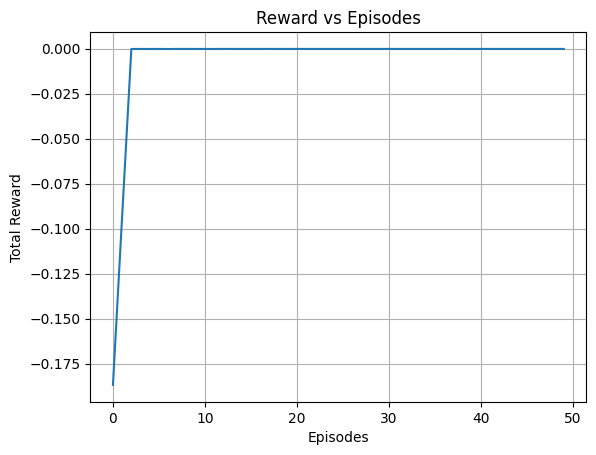

Episode 1/10, Total Reward: -0.00014999999999999974
Episode 2/10, Total Reward: -0.00014999999999999974
Episode 3/10, Total Reward: -0.00014999999999999974
Episode 4/10, Total Reward: -0.00014999999999999974
Episode 5/10, Total Reward: -0.00014999999999999974
Episode 6/10, Total Reward: -0.00014999999999999974
Episode 7/10, Total Reward: -0.00014999999999999974
Episode 8/10, Total Reward: -0.00014999999999999974
Episode 9/10, Total Reward: -0.00014999999999999974
Episode 10/10, Total Reward: -0.00014999999999999974
Parameters: {'learning_rate': 0.1, 'discount_factor': 0.9, 'exploration_rate': 1.0, 'exploration_decay': 0.99}, Average Reward: -0.00014999999999999974
New best parameters: {'learning_rate': 0.1, 'discount_factor': 0.9, 'exploration_rate': 1.0, 'exploration_decay': 0.99} with average reward: -0.00014999999999999974
Testing parameters: {'learning_rate': 0.1, 'discount_factor': 0.9, 'exploration_rate': 1.0, 'exploration_decay': 0.95}
Q-table loaded from q_table_1.pkl.
Episode 

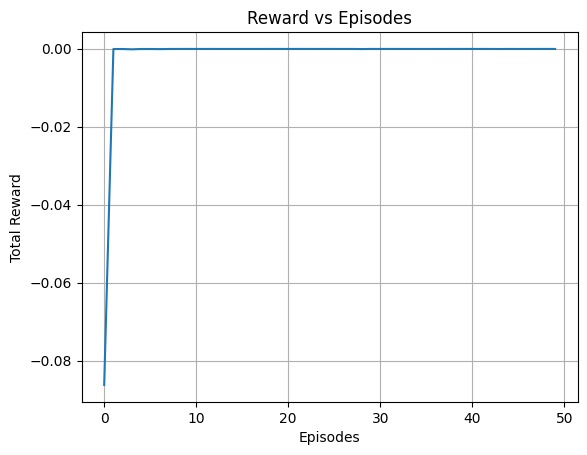

Episode 1/10, Total Reward: -0.00010099999999999981
Episode 2/10, Total Reward: -0.00010099999999999981
Episode 3/10, Total Reward: -0.00010099999999999981
Episode 4/10, Total Reward: -0.00010099999999999981
Episode 5/10, Total Reward: -0.00010099999999999981
Episode 6/10, Total Reward: -0.00010099999999999981
Episode 7/10, Total Reward: -0.00010099999999999981
Episode 8/10, Total Reward: -0.00010099999999999981
Episode 9/10, Total Reward: -0.00010099999999999981
Episode 10/10, Total Reward: -0.00010099999999999981
Parameters: {'learning_rate': 0.1, 'discount_factor': 0.9, 'exploration_rate': 1.0, 'exploration_decay': 0.95}, Average Reward: -0.00010099999999999981
New best parameters: {'learning_rate': 0.1, 'discount_factor': 0.9, 'exploration_rate': 1.0, 'exploration_decay': 0.95} with average reward: -0.00010099999999999981
Testing parameters: {'learning_rate': 0.1, 'discount_factor': 0.9, 'exploration_rate': 1.0, 'exploration_decay': 0.9}
Q-table loaded from q_table_2.pkl.
Episode 1

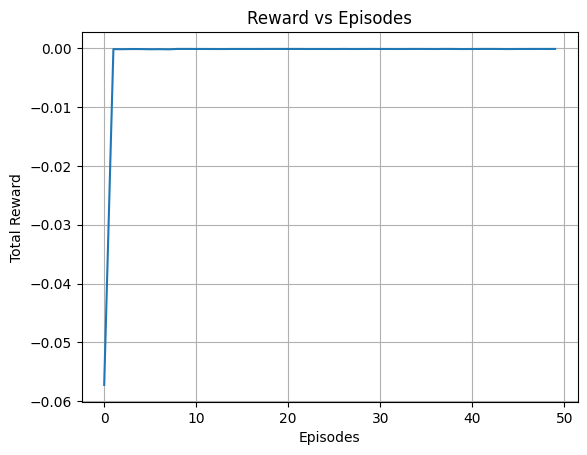

Episode 1/10, Total Reward: -0.00010099999999999981
Episode 2/10, Total Reward: -0.00010099999999999981
Episode 3/10, Total Reward: -0.00010099999999999981
Episode 4/10, Total Reward: -0.00010099999999999981
Episode 5/10, Total Reward: -0.00010099999999999981
Episode 6/10, Total Reward: -0.00010099999999999981
Episode 7/10, Total Reward: -0.00010099999999999981
Episode 8/10, Total Reward: -0.00010099999999999981
Episode 9/10, Total Reward: -0.00010099999999999981
Episode 10/10, Total Reward: -0.00010099999999999981
Parameters: {'learning_rate': 0.1, 'discount_factor': 0.9, 'exploration_rate': 1.0, 'exploration_decay': 0.9}, Average Reward: -0.00010099999999999981
Testing parameters: {'learning_rate': 0.1, 'discount_factor': 0.9, 'exploration_rate': 0.5, 'exploration_decay': 0.99}
Q-table loaded from q_table_3.pkl.
Episode 1/50, Total Reward: -0.056633000000000114
Episode 2/50, Total Reward: -0.05194700000000008
Episode 3/50, Total Reward: -0.0001899999999999997
Episode 4/50, Total Rewa

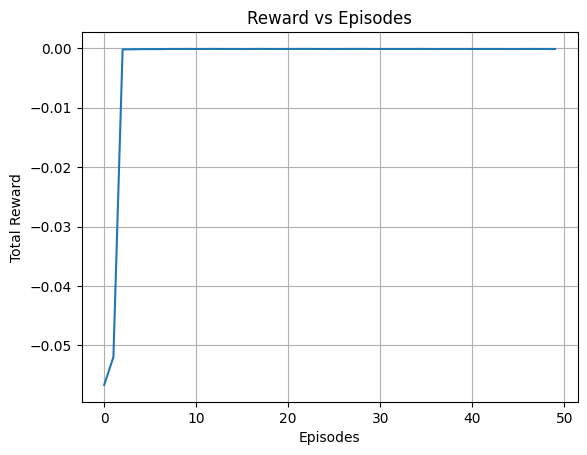

Episode 1/10, Total Reward: -0.00014999999999999974
Episode 2/10, Total Reward: -0.00014999999999999974
Episode 3/10, Total Reward: -0.00014999999999999974
Episode 4/10, Total Reward: -0.00014999999999999974
Episode 5/10, Total Reward: -0.00014999999999999974
Episode 6/10, Total Reward: -0.00014999999999999974
Episode 7/10, Total Reward: -0.00014999999999999974
Episode 8/10, Total Reward: -0.00014999999999999974
Episode 9/10, Total Reward: -0.00014999999999999974
Episode 10/10, Total Reward: -0.00014999999999999974
Parameters: {'learning_rate': 0.1, 'discount_factor': 0.9, 'exploration_rate': 0.5, 'exploration_decay': 0.99}, Average Reward: -0.00014999999999999974
Testing parameters: {'learning_rate': 0.1, 'discount_factor': 0.9, 'exploration_rate': 0.5, 'exploration_decay': 0.95}
Q-table loaded from q_table_4.pkl.
Episode 1/50, Total Reward: -0.20722000000000007
Episode 2/50, Total Reward: -0.00014599999999999975
Episode 3/50, Total Reward: -0.0001679999999999998
Episode 4/50, Total R

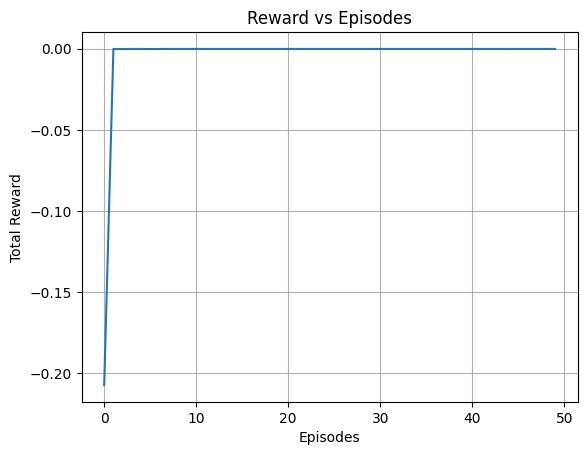

Episode 1/10, Total Reward: -0.00010099999999999981
Episode 2/10, Total Reward: -0.00010099999999999981
Episode 3/10, Total Reward: -0.00010099999999999981
Episode 4/10, Total Reward: -0.00010099999999999981
Episode 5/10, Total Reward: -0.00010099999999999981
Episode 6/10, Total Reward: -0.00010099999999999981
Episode 7/10, Total Reward: -0.00010099999999999981
Episode 8/10, Total Reward: -0.00010099999999999981
Episode 9/10, Total Reward: -0.00010099999999999981
Episode 10/10, Total Reward: -0.00010099999999999981
Parameters: {'learning_rate': 0.1, 'discount_factor': 0.9, 'exploration_rate': 0.5, 'exploration_decay': 0.95}, Average Reward: -0.00010099999999999981
Testing parameters: {'learning_rate': 0.1, 'discount_factor': 0.9, 'exploration_rate': 0.5, 'exploration_decay': 0.9}
Q-table loaded from q_table_5.pkl.
Episode 1/50, Total Reward: -0.003702000000000003
Episode 2/50, Total Reward: -0.00015499999999999976
Episode 3/50, Total Reward: -0.00014099999999999974
Episode 4/50, Total 

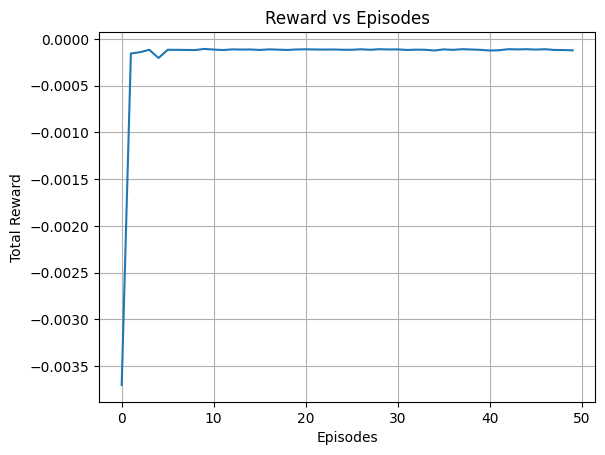

Episode 1/10, Total Reward: -0.00014899999999999975
Episode 2/10, Total Reward: -0.00014899999999999975
Episode 3/10, Total Reward: -0.00014899999999999975
Episode 4/10, Total Reward: -0.00014899999999999975
Episode 5/10, Total Reward: -0.00014899999999999975
Episode 6/10, Total Reward: -0.00014899999999999975
Episode 7/10, Total Reward: -0.00014899999999999975
Episode 8/10, Total Reward: -0.00014899999999999975
Episode 9/10, Total Reward: -0.00014899999999999975
Episode 10/10, Total Reward: -0.00014899999999999975
Parameters: {'learning_rate': 0.1, 'discount_factor': 0.9, 'exploration_rate': 0.5, 'exploration_decay': 0.9}, Average Reward: -0.00014899999999999977
Testing parameters: {'learning_rate': 0.1, 'discount_factor': 0.9, 'exploration_rate': 0.1, 'exploration_decay': 0.99}
Q-table loaded from q_table_6.pkl.
Episode 1/50, Total Reward: -0.07139400000000007
Episode 2/50, Total Reward: -0.00012399999999999982
Episode 3/50, Total Reward: -0.0001259999999999998
Episode 4/50, Total Re

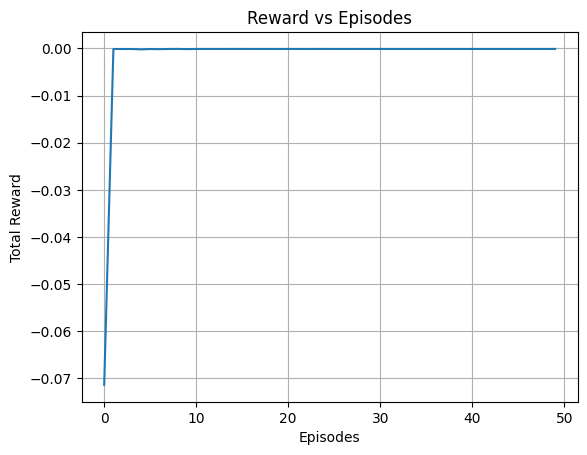

Episode 1/10, Total Reward: -0.00010099999999999981
Episode 2/10, Total Reward: -0.00010099999999999981
Episode 3/10, Total Reward: -0.00010099999999999981
Episode 4/10, Total Reward: -0.00010099999999999981
Episode 5/10, Total Reward: -0.00010099999999999981
Episode 6/10, Total Reward: -0.00010099999999999981
Episode 7/10, Total Reward: -0.00010099999999999981
Episode 8/10, Total Reward: -0.00010099999999999981
Episode 9/10, Total Reward: -0.00010099999999999981
Episode 10/10, Total Reward: -0.00010099999999999981
Parameters: {'learning_rate': 0.1, 'discount_factor': 0.9, 'exploration_rate': 0.1, 'exploration_decay': 0.99}, Average Reward: -0.00010099999999999981
Testing parameters: {'learning_rate': 0.1, 'discount_factor': 0.9, 'exploration_rate': 0.1, 'exploration_decay': 0.95}
Q-table loaded from q_table_7.pkl.
Episode 1/50, Total Reward: -0.0001289999999999998
Episode 2/50, Total Reward: -0.00019199999999999976
Episode 3/50, Total Reward: -0.00014999999999999977
Episode 4/50, Tota

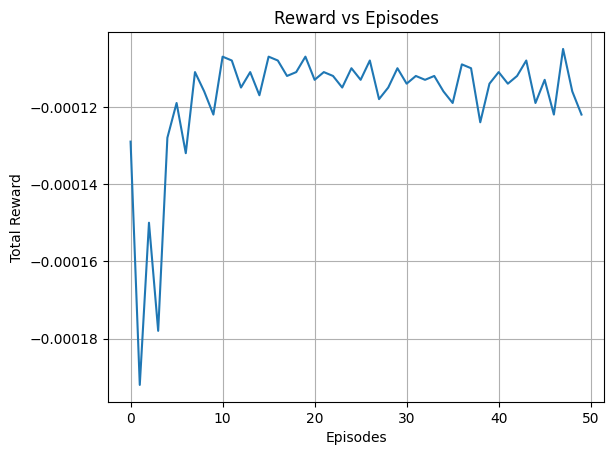

Episode 1/10, Total Reward: -0.00010099999999999981
Episode 2/10, Total Reward: -0.00010099999999999981
Episode 3/10, Total Reward: -0.00010099999999999981
Episode 4/10, Total Reward: -0.00010099999999999981
Episode 5/10, Total Reward: -0.00010099999999999981
Episode 6/10, Total Reward: -0.00010099999999999981
Episode 7/10, Total Reward: -0.00010099999999999981
Episode 8/10, Total Reward: -0.00010099999999999981
Episode 9/10, Total Reward: -0.00010099999999999981
Episode 10/10, Total Reward: -0.00010099999999999981
Parameters: {'learning_rate': 0.1, 'discount_factor': 0.9, 'exploration_rate': 0.1, 'exploration_decay': 0.95}, Average Reward: -0.00010099999999999981
Testing parameters: {'learning_rate': 0.1, 'discount_factor': 0.9, 'exploration_rate': 0.1, 'exploration_decay': 0.9}
Q-table loaded from q_table_8.pkl.
Episode 1/50, Total Reward: -0.030313000000000038
Episode 2/50, Total Reward: -0.00013299999999999976
Episode 3/50, Total Reward: -0.00016599999999999978
Episode 4/50, Total 

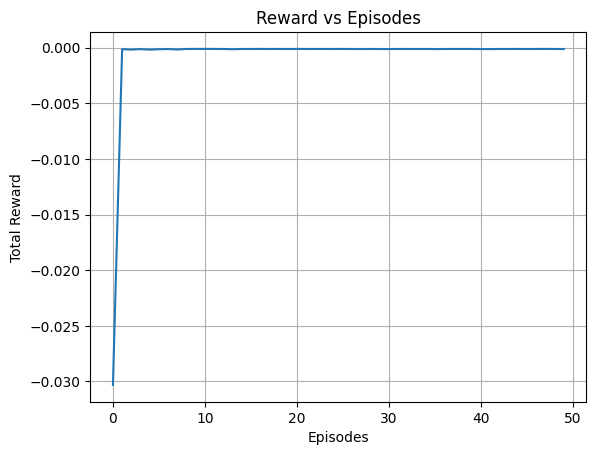

Episode 1/10, Total Reward: -0.00010099999999999981
Episode 2/10, Total Reward: -0.00010099999999999981
Episode 3/10, Total Reward: -0.00010099999999999981
Episode 4/10, Total Reward: -0.00010099999999999981
Episode 5/10, Total Reward: -0.00010099999999999981
Episode 6/10, Total Reward: -0.00010099999999999981
Episode 7/10, Total Reward: -0.00010099999999999981
Episode 8/10, Total Reward: -0.00010099999999999981
Episode 9/10, Total Reward: -0.00010099999999999981
Episode 10/10, Total Reward: -0.00010099999999999981
Parameters: {'learning_rate': 0.1, 'discount_factor': 0.9, 'exploration_rate': 0.1, 'exploration_decay': 0.9}, Average Reward: -0.00010099999999999981
Testing parameters: {'learning_rate': 0.1, 'discount_factor': 0.95, 'exploration_rate': 1.0, 'exploration_decay': 0.99}
Q-table loaded from q_table_9.pkl.
Episode 1/50, Total Reward: -0.27048799999999984
Episode 2/50, Total Reward: -0.18537000000000012
Episode 3/50, Total Reward: -0.029626000000000027
Episode 4/50, Total Rewar

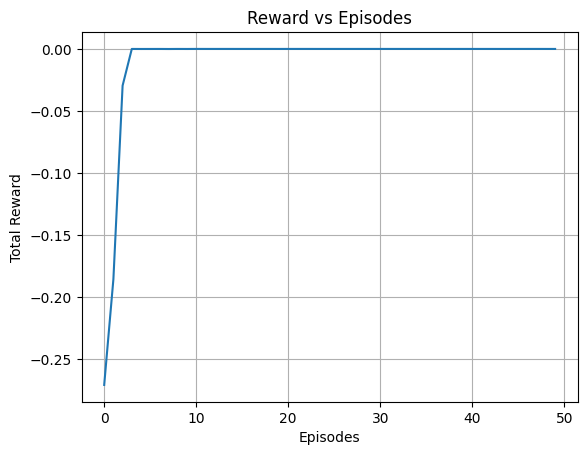

Episode 1/10, Total Reward: -9.999999999999982e-05
Episode 2/10, Total Reward: -9.999999999999982e-05
Episode 3/10, Total Reward: -9.999999999999982e-05
Episode 4/10, Total Reward: -9.999999999999982e-05
Episode 5/10, Total Reward: -9.999999999999982e-05
Episode 6/10, Total Reward: -9.999999999999982e-05
Episode 7/10, Total Reward: -9.999999999999982e-05
Episode 8/10, Total Reward: -9.999999999999982e-05
Episode 9/10, Total Reward: -9.999999999999982e-05
Episode 10/10, Total Reward: -9.999999999999982e-05
Parameters: {'learning_rate': 0.1, 'discount_factor': 0.95, 'exploration_rate': 1.0, 'exploration_decay': 0.99}, Average Reward: -9.99999999999998e-05
New best parameters: {'learning_rate': 0.1, 'discount_factor': 0.95, 'exploration_rate': 1.0, 'exploration_decay': 0.99} with average reward: -9.99999999999998e-05
Testing parameters: {'learning_rate': 0.1, 'discount_factor': 0.95, 'exploration_rate': 1.0, 'exploration_decay': 0.95}
Q-table loaded from q_table_10.pkl.
Episode 1/50, Tota

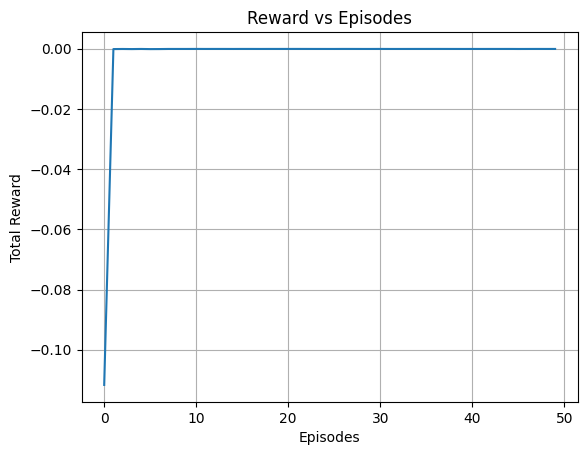

Episode 1/10, Total Reward: -9.999999999999982e-05
Episode 2/10, Total Reward: -9.999999999999982e-05
Episode 3/10, Total Reward: -9.999999999999982e-05
Episode 4/10, Total Reward: -9.999999999999982e-05
Episode 5/10, Total Reward: -9.999999999999982e-05
Episode 6/10, Total Reward: -9.999999999999982e-05
Episode 7/10, Total Reward: -9.999999999999982e-05
Episode 8/10, Total Reward: -9.999999999999982e-05
Episode 9/10, Total Reward: -9.999999999999982e-05
Episode 10/10, Total Reward: -9.999999999999982e-05
Parameters: {'learning_rate': 0.1, 'discount_factor': 0.95, 'exploration_rate': 1.0, 'exploration_decay': 0.95}, Average Reward: -9.99999999999998e-05
Testing parameters: {'learning_rate': 0.1, 'discount_factor': 0.95, 'exploration_rate': 1.0, 'exploration_decay': 0.9}
Q-table loaded from q_table_11.pkl.
Episode 1/50, Total Reward: -0.0001699999999999998
Episode 2/50, Total Reward: -0.00014199999999999977
Episode 3/50, Total Reward: -0.0001239999999999998
Episode 4/50, Total Reward: -

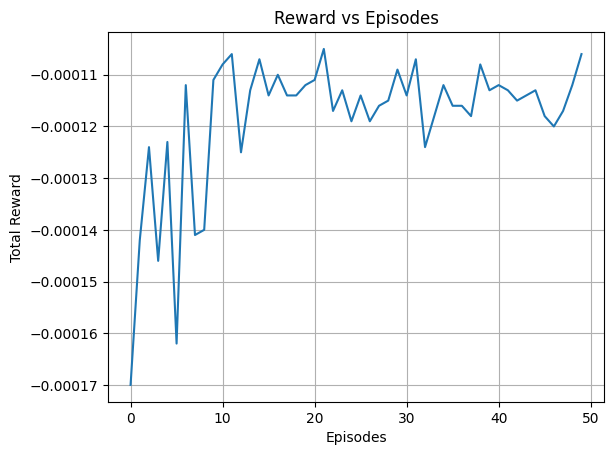

Episode 1/10, Total Reward: -9.999999999999982e-05
Episode 2/10, Total Reward: -9.999999999999982e-05
Episode 3/10, Total Reward: -9.999999999999982e-05
Episode 4/10, Total Reward: -9.999999999999982e-05
Episode 5/10, Total Reward: -9.999999999999982e-05
Episode 6/10, Total Reward: -9.999999999999982e-05
Episode 7/10, Total Reward: -9.999999999999982e-05
Episode 8/10, Total Reward: -9.999999999999982e-05
Episode 9/10, Total Reward: -9.999999999999982e-05
Episode 10/10, Total Reward: -9.999999999999982e-05
Parameters: {'learning_rate': 0.1, 'discount_factor': 0.95, 'exploration_rate': 1.0, 'exploration_decay': 0.9}, Average Reward: -9.99999999999998e-05
Testing parameters: {'learning_rate': 0.1, 'discount_factor': 0.95, 'exploration_rate': 0.5, 'exploration_decay': 0.99}
Q-table loaded from q_table_12.pkl.
Episode 1/50, Total Reward: -0.09431600000000008
Episode 2/50, Total Reward: -0.019759000000000002
Episode 3/50, Total Reward: -0.0001369999999999998
Episode 4/50, Total Reward: -0.00

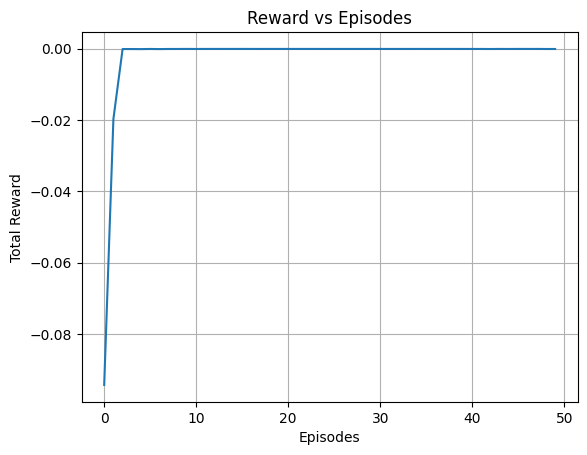

Episode 1/10, Total Reward: -9.999999999999982e-05
Episode 2/10, Total Reward: -9.999999999999982e-05
Episode 3/10, Total Reward: -9.999999999999982e-05
Episode 4/10, Total Reward: -9.999999999999982e-05
Episode 5/10, Total Reward: -9.999999999999982e-05
Episode 6/10, Total Reward: -9.999999999999982e-05
Episode 7/10, Total Reward: -9.999999999999982e-05
Episode 8/10, Total Reward: -9.999999999999982e-05
Episode 9/10, Total Reward: -9.999999999999982e-05
Episode 10/10, Total Reward: -9.999999999999982e-05
Parameters: {'learning_rate': 0.1, 'discount_factor': 0.95, 'exploration_rate': 0.5, 'exploration_decay': 0.99}, Average Reward: -9.99999999999998e-05
Testing parameters: {'learning_rate': 0.1, 'discount_factor': 0.95, 'exploration_rate': 0.5, 'exploration_decay': 0.95}
Q-table loaded from q_table_13.pkl.
Episode 1/50, Total Reward: -0.03906800000000011
Episode 2/50, Total Reward: -0.00017899999999999977
Episode 3/50, Total Reward: -0.0001579999999999998
Episode 4/50, Total Reward: -0

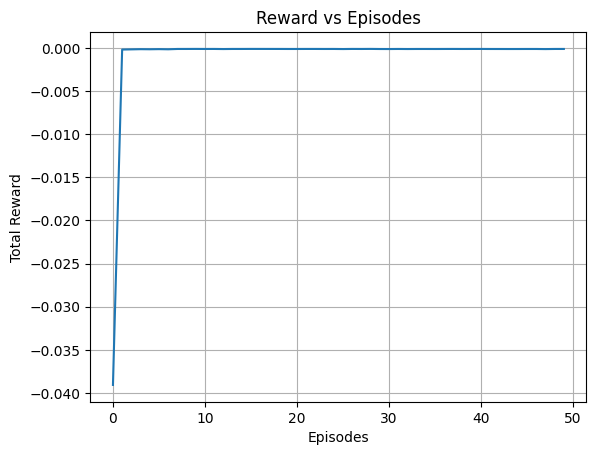

Episode 1/10, Total Reward: -0.0005330000000000012
Episode 2/10, Total Reward: -0.0005330000000000012
Episode 3/10, Total Reward: -0.0005330000000000012
Episode 4/10, Total Reward: -0.0005330000000000012
Episode 5/10, Total Reward: -0.0005330000000000012
Episode 6/10, Total Reward: -0.0005330000000000012
Episode 7/10, Total Reward: -0.0005330000000000012
Episode 8/10, Total Reward: -0.0005330000000000012
Episode 9/10, Total Reward: -0.0005330000000000012
Episode 10/10, Total Reward: -0.0005330000000000012
Parameters: {'learning_rate': 0.1, 'discount_factor': 0.95, 'exploration_rate': 0.5, 'exploration_decay': 0.95}, Average Reward: -0.0005330000000000012
Testing parameters: {'learning_rate': 0.1, 'discount_factor': 0.95, 'exploration_rate': 0.5, 'exploration_decay': 0.9}
Q-table loaded from q_table_14.pkl.
Episode 1/50, Total Reward: -0.03562100000000011
Episode 2/50, Total Reward: -0.00014799999999999978
Episode 3/50, Total Reward: -0.00014699999999999978
Episode 4/50, Total Reward: -

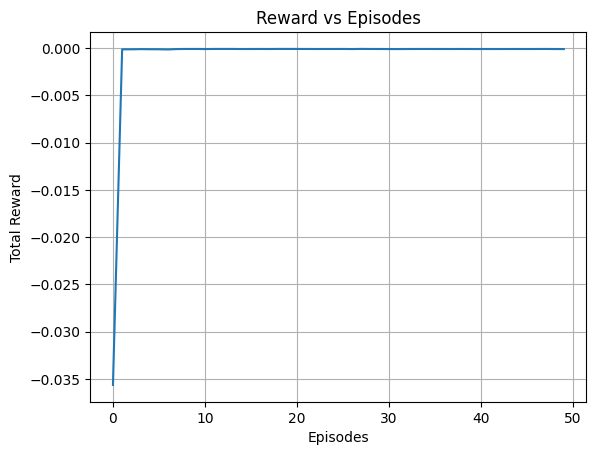

Episode 1/10, Total Reward: -0.00010199999999999981
Episode 2/10, Total Reward: -0.00010199999999999981
Episode 3/10, Total Reward: -0.00010199999999999981
Episode 4/10, Total Reward: -0.00010199999999999981
Episode 5/10, Total Reward: -0.00010199999999999981
Episode 6/10, Total Reward: -0.00010199999999999981
Episode 7/10, Total Reward: -0.00010199999999999981
Episode 8/10, Total Reward: -0.00010199999999999981
Episode 9/10, Total Reward: -0.00010199999999999981
Episode 10/10, Total Reward: -0.00010199999999999981
Parameters: {'learning_rate': 0.1, 'discount_factor': 0.95, 'exploration_rate': 0.5, 'exploration_decay': 0.9}, Average Reward: -0.00010199999999999981
Testing parameters: {'learning_rate': 0.1, 'discount_factor': 0.95, 'exploration_rate': 0.1, 'exploration_decay': 0.99}
Q-table loaded from q_table_15.pkl.
Episode 1/50, Total Reward: -0.03931700000000007
Episode 2/50, Total Reward: -0.16522900000000007
Episode 3/50, Total Reward: -0.00014499999999999978
Episode 4/50, Total R

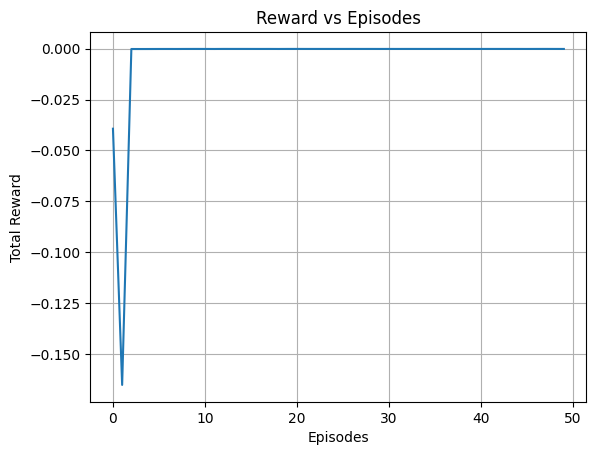

Episode 1/10, Total Reward: -9.999999999999982e-05
Episode 2/10, Total Reward: -9.999999999999982e-05
Episode 3/10, Total Reward: -9.999999999999982e-05
Episode 4/10, Total Reward: -9.999999999999982e-05
Episode 5/10, Total Reward: -9.999999999999982e-05
Episode 6/10, Total Reward: -9.999999999999982e-05
Episode 7/10, Total Reward: -9.999999999999982e-05
Episode 8/10, Total Reward: -9.999999999999982e-05
Episode 9/10, Total Reward: -9.999999999999982e-05
Episode 10/10, Total Reward: -9.999999999999982e-05
Parameters: {'learning_rate': 0.1, 'discount_factor': 0.95, 'exploration_rate': 0.1, 'exploration_decay': 0.99}, Average Reward: -9.99999999999998e-05
Testing parameters: {'learning_rate': 0.1, 'discount_factor': 0.95, 'exploration_rate': 0.1, 'exploration_decay': 0.95}
Q-table loaded from q_table_16.pkl.
Episode 1/50, Total Reward: -0.0001409999999999998
Episode 2/50, Total Reward: -0.00014799999999999975
Episode 3/50, Total Reward: -0.0001499999999999998
Episode 4/50, Total Reward: 

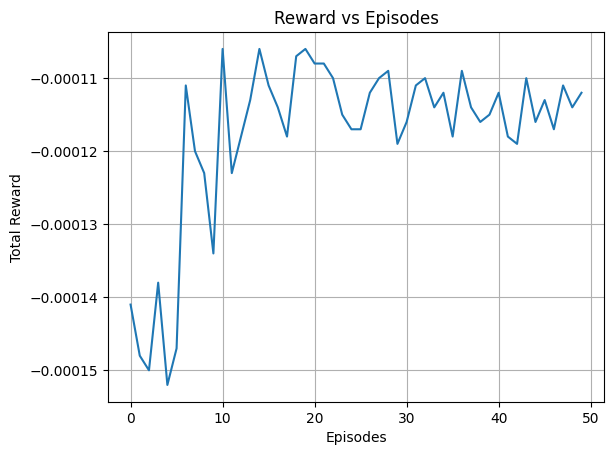

Episode 1/10, Total Reward: -0.00010099999999999981
Episode 2/10, Total Reward: -0.00010099999999999981
Episode 3/10, Total Reward: -0.00010099999999999981
Episode 4/10, Total Reward: -0.00010099999999999981
Episode 5/10, Total Reward: -0.00010099999999999981
Episode 6/10, Total Reward: -0.00010099999999999981
Episode 7/10, Total Reward: -0.00010099999999999981
Episode 8/10, Total Reward: -0.00010099999999999981
Episode 9/10, Total Reward: -0.00010099999999999981
Episode 10/10, Total Reward: -0.00010099999999999981
Parameters: {'learning_rate': 0.1, 'discount_factor': 0.95, 'exploration_rate': 0.1, 'exploration_decay': 0.95}, Average Reward: -0.00010099999999999981
Testing parameters: {'learning_rate': 0.1, 'discount_factor': 0.95, 'exploration_rate': 0.1, 'exploration_decay': 0.9}
Q-table loaded from q_table_17.pkl.
Episode 1/50, Total Reward: -0.0001399999999999998
Episode 2/50, Total Reward: -0.00015599999999999975
Episode 3/50, Total Reward: -0.00014199999999999977
Episode 4/50, To

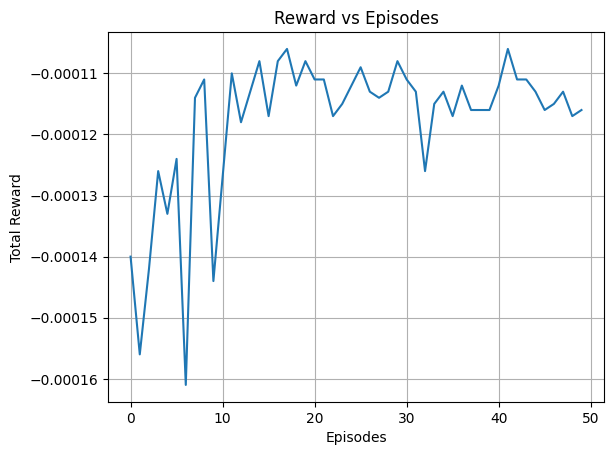

Episode 1/10, Total Reward: -9.999999999999982e-05
Episode 2/10, Total Reward: -9.999999999999982e-05
Episode 3/10, Total Reward: -9.999999999999982e-05
Episode 4/10, Total Reward: -9.999999999999982e-05
Episode 5/10, Total Reward: -9.999999999999982e-05
Episode 6/10, Total Reward: -9.999999999999982e-05
Episode 7/10, Total Reward: -9.999999999999982e-05
Episode 8/10, Total Reward: -9.999999999999982e-05
Episode 9/10, Total Reward: -9.999999999999982e-05
Episode 10/10, Total Reward: -9.999999999999982e-05
Parameters: {'learning_rate': 0.1, 'discount_factor': 0.95, 'exploration_rate': 0.1, 'exploration_decay': 0.9}, Average Reward: -9.99999999999998e-05
Testing parameters: {'learning_rate': 0.1, 'discount_factor': 0.99, 'exploration_rate': 1.0, 'exploration_decay': 0.99}
Q-table loaded from q_table_18.pkl.
Episode 1/50, Total Reward: -0.21202600000000008
Episode 2/50, Total Reward: -0.09188900000000011
Episode 3/50, Total Reward: -0.00016699999999999975
Episode 4/50, Total Reward: -0.00

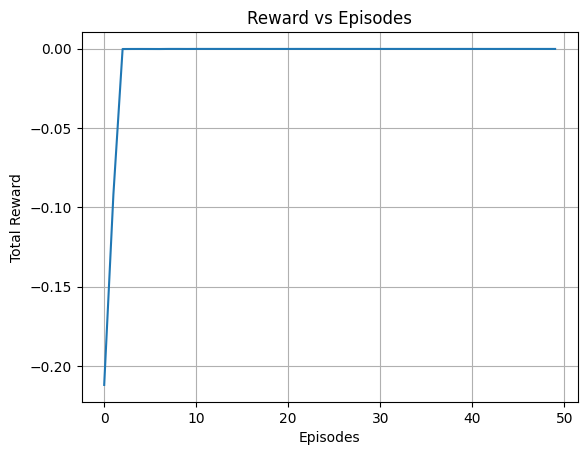

Episode 1/10, Total Reward: -0.00019799999999999964
Episode 2/10, Total Reward: -0.00019799999999999964
Episode 3/10, Total Reward: -0.00019799999999999964
Episode 4/10, Total Reward: -0.00019799999999999964
Episode 5/10, Total Reward: -0.00019799999999999964
Episode 6/10, Total Reward: -0.00019799999999999964
Episode 7/10, Total Reward: -0.00019799999999999964
Episode 8/10, Total Reward: -0.00019799999999999964
Episode 9/10, Total Reward: -0.00019799999999999964
Episode 10/10, Total Reward: -0.00019799999999999964
Parameters: {'learning_rate': 0.1, 'discount_factor': 0.99, 'exploration_rate': 1.0, 'exploration_decay': 0.99}, Average Reward: -0.00019799999999999966
Testing parameters: {'learning_rate': 0.1, 'discount_factor': 0.99, 'exploration_rate': 1.0, 'exploration_decay': 0.95}
Q-table loaded from q_table_19.pkl.
Episode 1/50, Total Reward: -0.1191710000000001
Episode 2/50, Total Reward: -0.00013399999999999976
Episode 3/50, Total Reward: -0.00013599999999999975
Episode 4/50, Tota

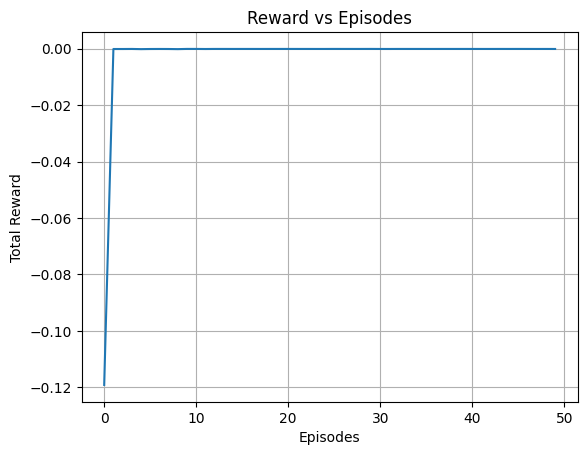

Episode 1/10, Total Reward: -9.999999999999982e-05
Episode 2/10, Total Reward: -9.999999999999982e-05
Episode 3/10, Total Reward: -9.999999999999982e-05
Episode 4/10, Total Reward: -9.999999999999982e-05
Episode 5/10, Total Reward: -9.999999999999982e-05
Episode 6/10, Total Reward: -9.999999999999982e-05
Episode 7/10, Total Reward: -9.999999999999982e-05
Episode 8/10, Total Reward: -9.999999999999982e-05
Episode 9/10, Total Reward: -9.999999999999982e-05
Episode 10/10, Total Reward: -9.999999999999982e-05
Parameters: {'learning_rate': 0.1, 'discount_factor': 0.99, 'exploration_rate': 1.0, 'exploration_decay': 0.95}, Average Reward: -9.99999999999998e-05
Testing parameters: {'learning_rate': 0.1, 'discount_factor': 0.99, 'exploration_rate': 1.0, 'exploration_decay': 0.9}
Q-table loaded from q_table_20.pkl.
Episode 1/50, Total Reward: -0.22800600000000013
Episode 2/50, Total Reward: -0.0001459999999999998
Episode 3/50, Total Reward: -0.00015099999999999974
Episode 4/50, Total Reward: -0.

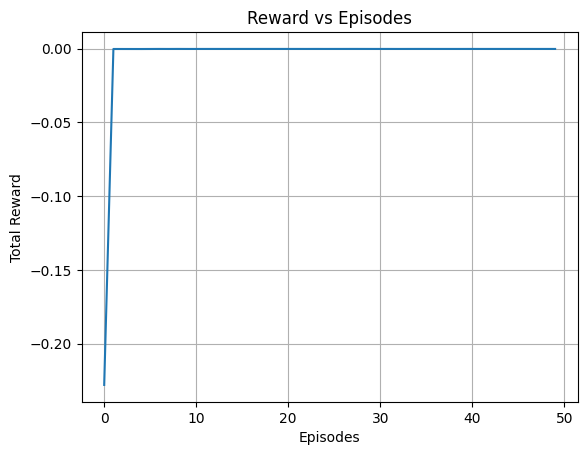

Episode 1/10, Total Reward: -9.999999999999982e-05
Episode 2/10, Total Reward: -9.999999999999982e-05
Episode 3/10, Total Reward: -9.999999999999982e-05
Episode 4/10, Total Reward: -9.999999999999982e-05
Episode 5/10, Total Reward: -9.999999999999982e-05
Episode 6/10, Total Reward: -9.999999999999982e-05
Episode 7/10, Total Reward: -9.999999999999982e-05
Episode 8/10, Total Reward: -9.999999999999982e-05
Episode 9/10, Total Reward: -9.999999999999982e-05
Episode 10/10, Total Reward: -9.999999999999982e-05
Parameters: {'learning_rate': 0.1, 'discount_factor': 0.99, 'exploration_rate': 1.0, 'exploration_decay': 0.9}, Average Reward: -9.99999999999998e-05
Testing parameters: {'learning_rate': 0.1, 'discount_factor': 0.99, 'exploration_rate': 0.5, 'exploration_decay': 0.99}
Q-table loaded from q_table_21.pkl.
Episode 1/50, Total Reward: -0.2717480000000001
Episode 2/50, Total Reward: -0.04921300000000004
Episode 3/50, Total Reward: -0.00013099999999999982
Episode 4/50, Total Reward: -0.000

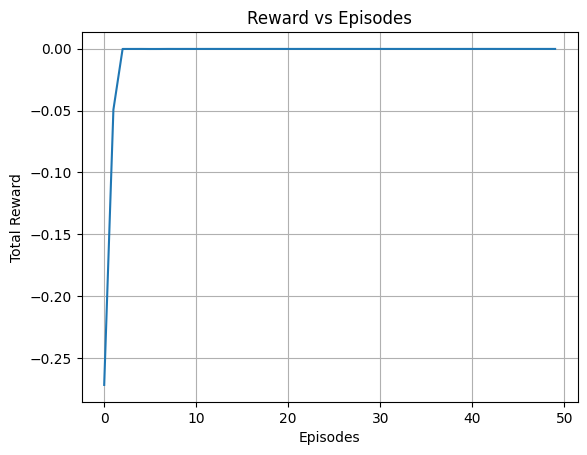

Episode 1/10, Total Reward: -0.0001159999999999998
Episode 2/10, Total Reward: -0.0001159999999999998
Episode 3/10, Total Reward: -0.0001159999999999998
Episode 4/10, Total Reward: -0.0001159999999999998
Episode 5/10, Total Reward: -0.0001159999999999998
Episode 6/10, Total Reward: -0.0001159999999999998
Episode 7/10, Total Reward: -0.0001159999999999998
Episode 8/10, Total Reward: -0.0001159999999999998
Episode 9/10, Total Reward: -0.0001159999999999998
Episode 10/10, Total Reward: -0.0001159999999999998
Parameters: {'learning_rate': 0.1, 'discount_factor': 0.99, 'exploration_rate': 0.5, 'exploration_decay': 0.99}, Average Reward: -0.00011599999999999981
Testing parameters: {'learning_rate': 0.1, 'discount_factor': 0.99, 'exploration_rate': 0.5, 'exploration_decay': 0.95}
Q-table loaded from q_table_22.pkl.
Episode 1/50, Total Reward: -0.06293300000000009
Episode 2/50, Total Reward: -0.00016999999999999982
Episode 3/50, Total Reward: -0.00015499999999999978
Episode 4/50, Total Reward:

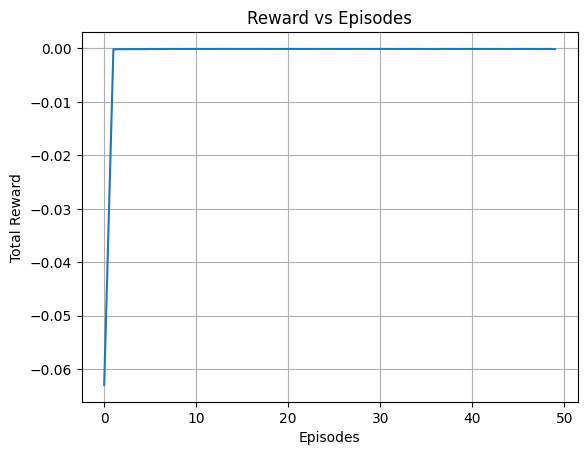

Episode 1/10, Total Reward: -0.00010099999999999981
Episode 2/10, Total Reward: -0.00010099999999999981
Episode 3/10, Total Reward: -0.00010099999999999981
Episode 4/10, Total Reward: -0.00010099999999999981
Episode 5/10, Total Reward: -0.00010099999999999981
Episode 6/10, Total Reward: -0.00010099999999999981
Episode 7/10, Total Reward: -0.00010099999999999981
Episode 8/10, Total Reward: -0.00010099999999999981
Episode 9/10, Total Reward: -0.00010099999999999981
Episode 10/10, Total Reward: -0.00010099999999999981
Parameters: {'learning_rate': 0.1, 'discount_factor': 0.99, 'exploration_rate': 0.5, 'exploration_decay': 0.95}, Average Reward: -0.00010099999999999981
Testing parameters: {'learning_rate': 0.1, 'discount_factor': 0.99, 'exploration_rate': 0.5, 'exploration_decay': 0.9}
Q-table loaded from q_table_23.pkl.
Episode 1/50, Total Reward: -0.0001689999999999998
Episode 2/50, Total Reward: -0.0001419999999999998
Episode 3/50, Total Reward: -0.0001339999999999998
Episode 4/50, Tota

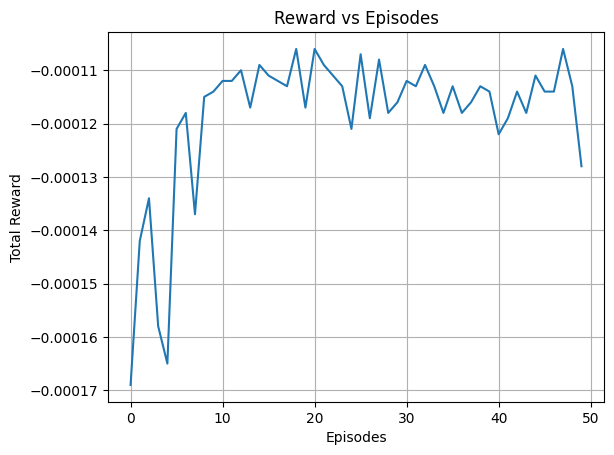

Episode 1/10, Total Reward: -0.00010199999999999981
Episode 2/10, Total Reward: -0.00010199999999999981
Episode 3/10, Total Reward: -0.00010199999999999981
Episode 4/10, Total Reward: -0.00010199999999999981
Episode 5/10, Total Reward: -0.00010199999999999981
Episode 6/10, Total Reward: -0.00010199999999999981
Episode 7/10, Total Reward: -0.00010199999999999981
Episode 8/10, Total Reward: -0.00010199999999999981
Episode 9/10, Total Reward: -0.00010199999999999981
Episode 10/10, Total Reward: -0.00010199999999999981
Parameters: {'learning_rate': 0.1, 'discount_factor': 0.99, 'exploration_rate': 0.5, 'exploration_decay': 0.9}, Average Reward: -0.00010199999999999981
Testing parameters: {'learning_rate': 0.1, 'discount_factor': 0.99, 'exploration_rate': 0.1, 'exploration_decay': 0.99}
Q-table loaded from q_table_24.pkl.
Episode 1/50, Total Reward: -0.019721000000000013
Episode 2/50, Total Reward: -0.00012599999999999978
Episode 3/50, Total Reward: -0.00015499999999999978
Episode 4/50, Tot

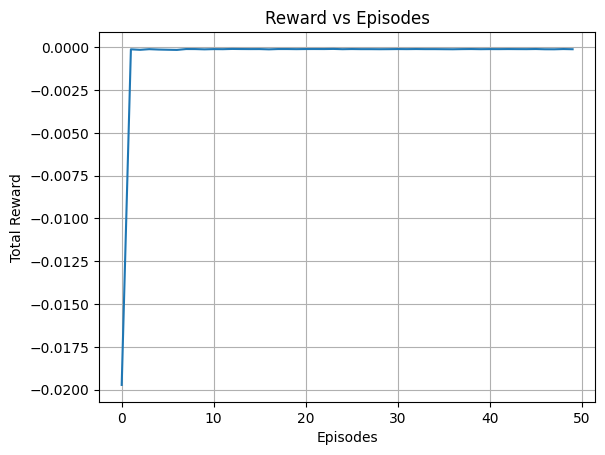

Episode 1/10, Total Reward: -9.999999999999982e-05
Episode 2/10, Total Reward: -9.999999999999982e-05
Episode 3/10, Total Reward: -9.999999999999982e-05
Episode 4/10, Total Reward: -9.999999999999982e-05
Episode 5/10, Total Reward: -9.999999999999982e-05
Episode 6/10, Total Reward: -9.999999999999982e-05
Episode 7/10, Total Reward: -9.999999999999982e-05
Episode 8/10, Total Reward: -9.999999999999982e-05
Episode 9/10, Total Reward: -9.999999999999982e-05
Episode 10/10, Total Reward: -9.999999999999982e-05
Parameters: {'learning_rate': 0.1, 'discount_factor': 0.99, 'exploration_rate': 0.1, 'exploration_decay': 0.99}, Average Reward: -9.99999999999998e-05
Testing parameters: {'learning_rate': 0.1, 'discount_factor': 0.99, 'exploration_rate': 0.1, 'exploration_decay': 0.95}
Q-table loaded from q_table_25.pkl.
Episode 1/50, Total Reward: -0.00015099999999999982
Episode 2/50, Total Reward: -0.00014599999999999975
Episode 3/50, Total Reward: -0.00012599999999999978
Episode 4/50, Total Reward

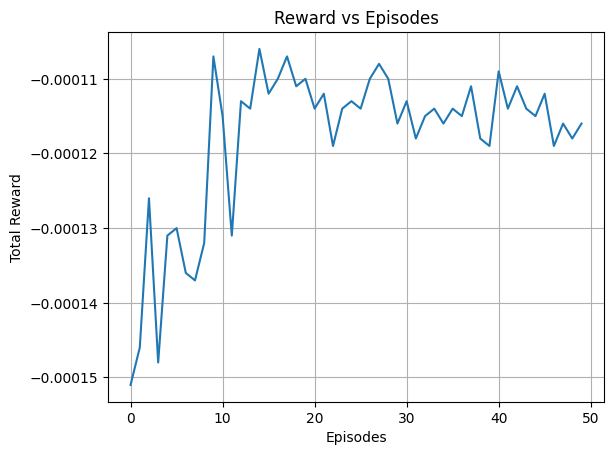

Episode 1/10, Total Reward: -9.999999999999982e-05
Episode 2/10, Total Reward: -9.999999999999982e-05
Episode 3/10, Total Reward: -9.999999999999982e-05
Episode 4/10, Total Reward: -9.999999999999982e-05
Episode 5/10, Total Reward: -9.999999999999982e-05
Episode 6/10, Total Reward: -9.999999999999982e-05
Episode 7/10, Total Reward: -9.999999999999982e-05
Episode 8/10, Total Reward: -9.999999999999982e-05
Episode 9/10, Total Reward: -9.999999999999982e-05
Episode 10/10, Total Reward: -9.999999999999982e-05
Parameters: {'learning_rate': 0.1, 'discount_factor': 0.99, 'exploration_rate': 0.1, 'exploration_decay': 0.95}, Average Reward: -9.99999999999998e-05
Testing parameters: {'learning_rate': 0.1, 'discount_factor': 0.99, 'exploration_rate': 0.1, 'exploration_decay': 0.9}
Q-table loaded from q_table_26.pkl.
Episode 1/50, Total Reward: -0.0001489999999999998
Episode 2/50, Total Reward: -0.0001419999999999998
Episode 3/50, Total Reward: -0.0001559999999999998
Episode 4/50, Total Reward: -0

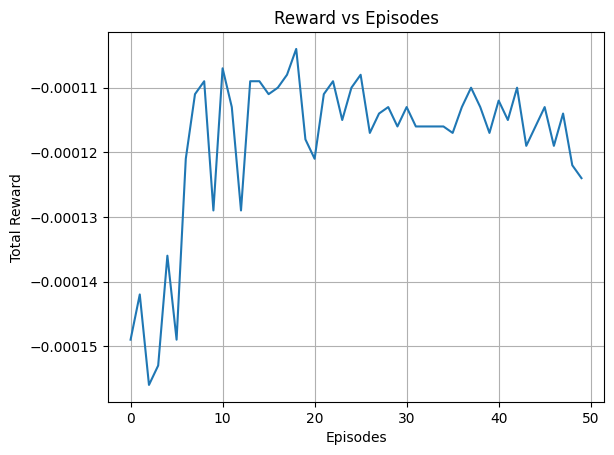

Episode 1/10, Total Reward: -0.0001029999999999998
Episode 2/10, Total Reward: -0.0001029999999999998
Episode 3/10, Total Reward: -0.0001029999999999998
Episode 4/10, Total Reward: -0.0001029999999999998
Episode 5/10, Total Reward: -0.0001029999999999998
Episode 6/10, Total Reward: -0.0001029999999999998
Episode 7/10, Total Reward: -0.0001029999999999998
Episode 8/10, Total Reward: -0.0001029999999999998
Episode 9/10, Total Reward: -0.0001029999999999998
Episode 10/10, Total Reward: -0.0001029999999999998
Parameters: {'learning_rate': 0.1, 'discount_factor': 0.99, 'exploration_rate': 0.1, 'exploration_decay': 0.9}, Average Reward: -0.00010299999999999982
Testing parameters: {'learning_rate': 0.01, 'discount_factor': 0.9, 'exploration_rate': 1.0, 'exploration_decay': 0.99}
Q-table loaded from q_table_27.pkl.
Episode 1/50, Total Reward: -0.13823300000000008
Episode 2/50, Total Reward: -0.1109070000000001
Episode 3/50, Total Reward: -0.00012899999999999975
Episode 4/50, Total Reward: -0.0

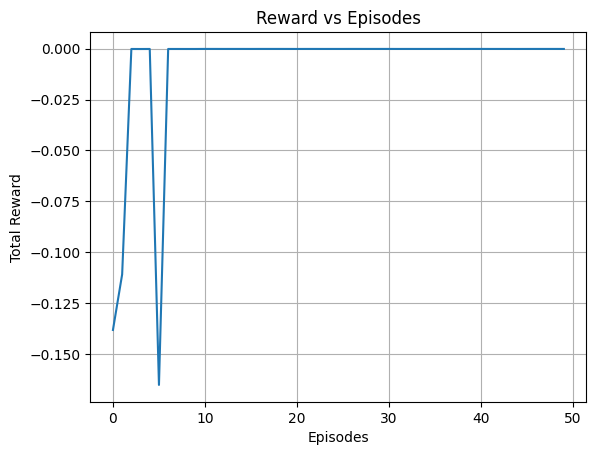

Episode 1/10, Total Reward: -9.999999999999982e-05
Episode 2/10, Total Reward: -9.999999999999982e-05
Episode 3/10, Total Reward: -9.999999999999982e-05
Episode 4/10, Total Reward: -9.999999999999982e-05
Episode 5/10, Total Reward: -9.999999999999982e-05
Episode 6/10, Total Reward: -9.999999999999982e-05
Episode 7/10, Total Reward: -9.999999999999982e-05
Episode 8/10, Total Reward: -9.999999999999982e-05
Episode 9/10, Total Reward: -9.999999999999982e-05
Episode 10/10, Total Reward: -9.999999999999982e-05
Parameters: {'learning_rate': 0.01, 'discount_factor': 0.9, 'exploration_rate': 1.0, 'exploration_decay': 0.99}, Average Reward: -9.99999999999998e-05
Testing parameters: {'learning_rate': 0.01, 'discount_factor': 0.9, 'exploration_rate': 1.0, 'exploration_decay': 0.95}
Q-table loaded from q_table_28.pkl.
Episode 1/50, Total Reward: -0.0654840000000001
Episode 2/50, Total Reward: -0.00014199999999999974
Episode 3/50, Total Reward: -0.00012299999999999976
Episode 4/50, Total Reward: -0

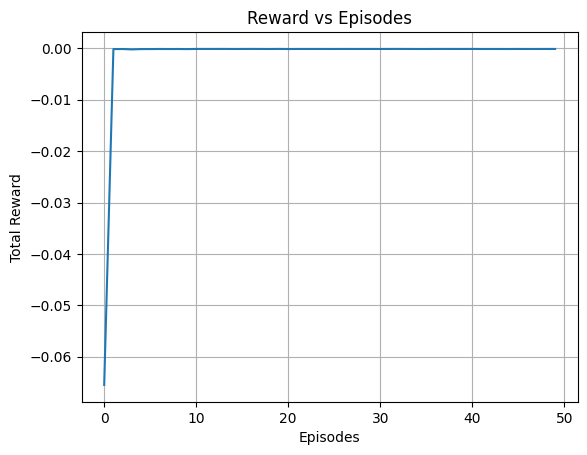

Episode 1/10, Total Reward: -9.999999999999982e-05
Episode 2/10, Total Reward: -9.999999999999982e-05
Episode 3/10, Total Reward: -9.999999999999982e-05
Episode 4/10, Total Reward: -9.999999999999982e-05
Episode 5/10, Total Reward: -9.999999999999982e-05
Episode 6/10, Total Reward: -9.999999999999982e-05
Episode 7/10, Total Reward: -9.999999999999982e-05
Episode 8/10, Total Reward: -9.999999999999982e-05
Episode 9/10, Total Reward: -9.999999999999982e-05
Episode 10/10, Total Reward: -9.999999999999982e-05
Parameters: {'learning_rate': 0.01, 'discount_factor': 0.9, 'exploration_rate': 1.0, 'exploration_decay': 0.95}, Average Reward: -9.99999999999998e-05
Testing parameters: {'learning_rate': 0.01, 'discount_factor': 0.9, 'exploration_rate': 1.0, 'exploration_decay': 0.9}
Q-table loaded from q_table_29.pkl.
Episode 1/50, Total Reward: -0.1119570000000001
Episode 2/50, Total Reward: -0.00014499999999999976
Episode 3/50, Total Reward: -0.00018799999999999975
Episode 4/50, Total Reward: -0.

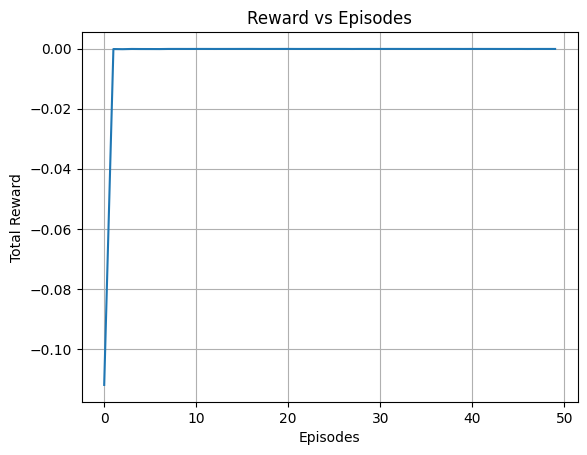

Episode 1/10, Total Reward: -0.00010099999999999981
Episode 2/10, Total Reward: -0.00010099999999999981
Episode 3/10, Total Reward: -0.00010099999999999981
Episode 4/10, Total Reward: -0.00010099999999999981
Episode 5/10, Total Reward: -0.00010099999999999981
Episode 6/10, Total Reward: -0.00010099999999999981
Episode 7/10, Total Reward: -0.00010099999999999981
Episode 8/10, Total Reward: -0.00010099999999999981
Episode 9/10, Total Reward: -0.00010099999999999981
Episode 10/10, Total Reward: -0.00010099999999999981
Parameters: {'learning_rate': 0.01, 'discount_factor': 0.9, 'exploration_rate': 1.0, 'exploration_decay': 0.9}, Average Reward: -0.00010099999999999981
Testing parameters: {'learning_rate': 0.01, 'discount_factor': 0.9, 'exploration_rate': 0.5, 'exploration_decay': 0.99}
Q-table loaded from q_table_30.pkl.
Episode 1/50, Total Reward: -0.3202159999999993
Episode 2/50, Total Reward: -0.01996900000000002
Episode 3/50, Total Reward: -0.00015599999999999978
Episode 4/50, Total Re

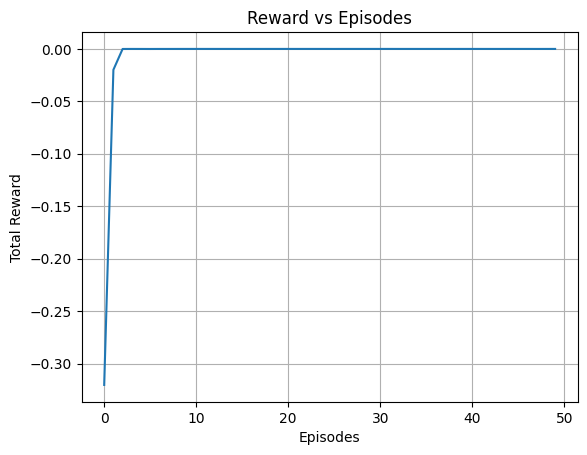

Episode 1/10, Total Reward: -9.999999999999982e-05
Episode 2/10, Total Reward: -9.999999999999982e-05
Episode 3/10, Total Reward: -9.999999999999982e-05
Episode 4/10, Total Reward: -9.999999999999982e-05
Episode 5/10, Total Reward: -9.999999999999982e-05
Episode 6/10, Total Reward: -9.999999999999982e-05
Episode 7/10, Total Reward: -9.999999999999982e-05
Episode 8/10, Total Reward: -9.999999999999982e-05
Episode 9/10, Total Reward: -9.999999999999982e-05
Episode 10/10, Total Reward: -9.999999999999982e-05
Parameters: {'learning_rate': 0.01, 'discount_factor': 0.9, 'exploration_rate': 0.5, 'exploration_decay': 0.99}, Average Reward: -9.99999999999998e-05
Testing parameters: {'learning_rate': 0.01, 'discount_factor': 0.9, 'exploration_rate': 0.5, 'exploration_decay': 0.95}
Q-table loaded from q_table_31.pkl.
Episode 1/50, Total Reward: -0.11609700000000013
Episode 2/50, Total Reward: -0.0001339999999999998
Episode 3/50, Total Reward: -0.0001289999999999998
Episode 4/50, Total Reward: -0.

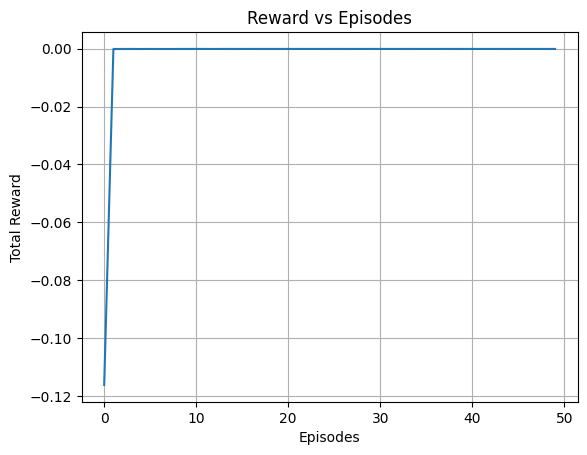

Episode 1/10, Total Reward: -9.999999999999982e-05
Episode 2/10, Total Reward: -9.999999999999982e-05
Episode 3/10, Total Reward: -9.999999999999982e-05
Episode 4/10, Total Reward: -9.999999999999982e-05
Episode 5/10, Total Reward: -9.999999999999982e-05
Episode 6/10, Total Reward: -9.999999999999982e-05
Episode 7/10, Total Reward: -9.999999999999982e-05
Episode 8/10, Total Reward: -9.999999999999982e-05
Episode 9/10, Total Reward: -9.999999999999982e-05
Episode 10/10, Total Reward: -9.999999999999982e-05
Parameters: {'learning_rate': 0.01, 'discount_factor': 0.9, 'exploration_rate': 0.5, 'exploration_decay': 0.95}, Average Reward: -9.99999999999998e-05
Testing parameters: {'learning_rate': 0.01, 'discount_factor': 0.9, 'exploration_rate': 0.5, 'exploration_decay': 0.9}
Q-table loaded from q_table_32.pkl.
Episode 1/50, Total Reward: -0.0001339999999999998
Episode 2/50, Total Reward: -0.00014299999999999976
Episode 3/50, Total Reward: -0.00015199999999999982
Episode 4/50, Total Reward: 

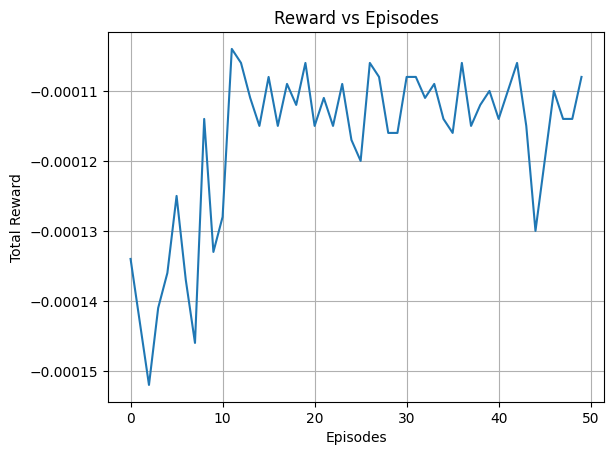

Episode 1/10, Total Reward: -0.00030000000000000035
Episode 2/10, Total Reward: -0.00030000000000000035
Episode 3/10, Total Reward: -0.00030000000000000035
Episode 4/10, Total Reward: -0.00030000000000000035
Episode 5/10, Total Reward: -0.00030000000000000035
Episode 6/10, Total Reward: -0.00030000000000000035
Episode 7/10, Total Reward: -0.00030000000000000035
Episode 8/10, Total Reward: -0.00030000000000000035
Episode 9/10, Total Reward: -0.00030000000000000035
Episode 10/10, Total Reward: -0.00030000000000000035
Parameters: {'learning_rate': 0.01, 'discount_factor': 0.9, 'exploration_rate': 0.5, 'exploration_decay': 0.9}, Average Reward: -0.00030000000000000035
Testing parameters: {'learning_rate': 0.01, 'discount_factor': 0.9, 'exploration_rate': 0.1, 'exploration_decay': 0.99}
Q-table loaded from q_table_33.pkl.
Episode 1/50, Total Reward: -0.021415000000000014
Episode 2/50, Total Reward: -0.019892000000000045
Episode 3/50, Total Reward: -0.029022000000000034
Episode 4/50, Total R

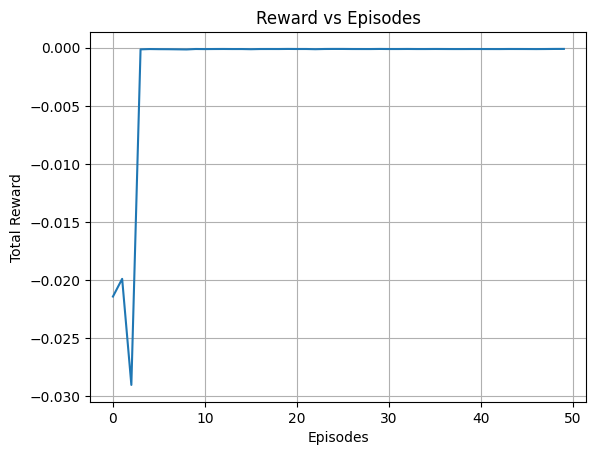

Episode 1/10, Total Reward: -0.00011199999999999981
Episode 2/10, Total Reward: -0.00011199999999999981
Episode 3/10, Total Reward: -0.00011199999999999981
Episode 4/10, Total Reward: -0.00011199999999999981
Episode 5/10, Total Reward: -0.00011199999999999981
Episode 6/10, Total Reward: -0.00011199999999999981
Episode 7/10, Total Reward: -0.00011199999999999981
Episode 8/10, Total Reward: -0.00011199999999999981
Episode 9/10, Total Reward: -0.00011199999999999981
Episode 10/10, Total Reward: -0.00011199999999999981
Parameters: {'learning_rate': 0.01, 'discount_factor': 0.9, 'exploration_rate': 0.1, 'exploration_decay': 0.99}, Average Reward: -0.00011199999999999982
Testing parameters: {'learning_rate': 0.01, 'discount_factor': 0.9, 'exploration_rate': 0.1, 'exploration_decay': 0.95}
Q-table loaded from q_table_34.pkl.
Episode 1/50, Total Reward: -0.0001209999999999998
Episode 2/50, Total Reward: -0.0001669999999999998
Episode 3/50, Total Reward: -0.0001269999999999998
Episode 4/50, Tot

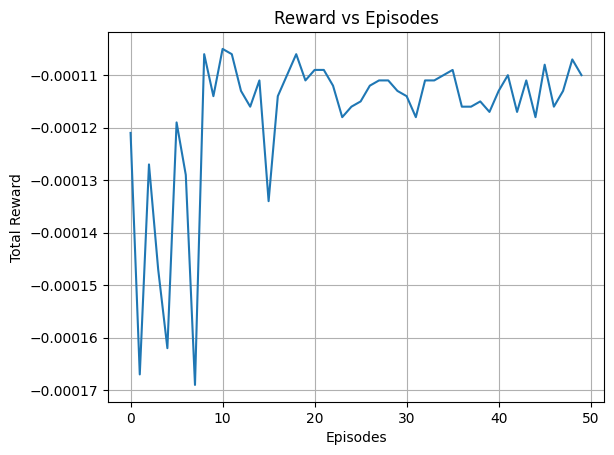

Episode 1/10, Total Reward: -0.00010199999999999981
Episode 2/10, Total Reward: -0.00010199999999999981
Episode 3/10, Total Reward: -0.00010199999999999981
Episode 4/10, Total Reward: -0.00010199999999999981
Episode 5/10, Total Reward: -0.00010199999999999981
Episode 6/10, Total Reward: -0.00010199999999999981
Episode 7/10, Total Reward: -0.00010199999999999981
Episode 8/10, Total Reward: -0.00010199999999999981
Episode 9/10, Total Reward: -0.00010199999999999981
Episode 10/10, Total Reward: -0.00010199999999999981
Parameters: {'learning_rate': 0.01, 'discount_factor': 0.9, 'exploration_rate': 0.1, 'exploration_decay': 0.95}, Average Reward: -0.00010199999999999981
Testing parameters: {'learning_rate': 0.01, 'discount_factor': 0.9, 'exploration_rate': 0.1, 'exploration_decay': 0.9}
Q-table loaded from q_table_35.pkl.
Episode 1/50, Total Reward: -0.00014199999999999982
Episode 2/50, Total Reward: -0.00014999999999999974
Episode 3/50, Total Reward: -0.00012899999999999983
Episode 4/50, T

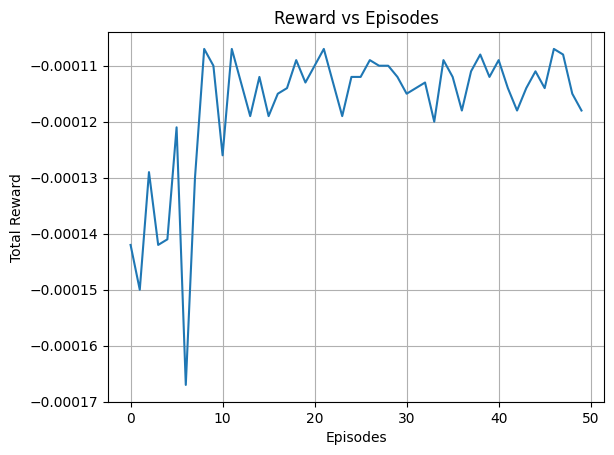

Episode 1/10, Total Reward: -0.00014899999999999975
Episode 2/10, Total Reward: -0.00014899999999999975
Episode 3/10, Total Reward: -0.00014899999999999975
Episode 4/10, Total Reward: -0.00014899999999999975
Episode 5/10, Total Reward: -0.00014899999999999975
Episode 6/10, Total Reward: -0.00014899999999999975
Episode 7/10, Total Reward: -0.00014899999999999975
Episode 8/10, Total Reward: -0.00014899999999999975
Episode 9/10, Total Reward: -0.00014899999999999975
Episode 10/10, Total Reward: -0.00014899999999999975
Parameters: {'learning_rate': 0.01, 'discount_factor': 0.9, 'exploration_rate': 0.1, 'exploration_decay': 0.9}, Average Reward: -0.00014899999999999977
Testing parameters: {'learning_rate': 0.01, 'discount_factor': 0.95, 'exploration_rate': 1.0, 'exploration_decay': 0.99}
Q-table loaded from q_table_36.pkl.
Episode 1/50, Total Reward: -0.28731499999999927
Episode 2/50, Total Reward: -0.04473300000000012
Episode 3/50, Total Reward: -0.039546000000000026
Episode 4/50, Total Re

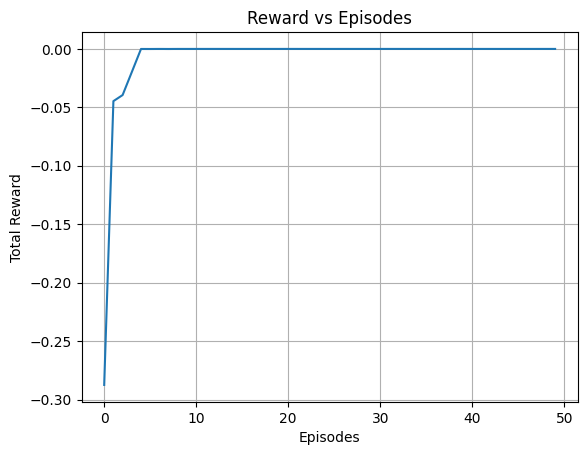

Episode 1/10, Total Reward: -0.0001239999999999998
Episode 2/10, Total Reward: -0.0001239999999999998
Episode 3/10, Total Reward: -0.0001239999999999998
Episode 4/10, Total Reward: -0.0001239999999999998
Episode 5/10, Total Reward: -0.0001239999999999998
Episode 6/10, Total Reward: -0.0001239999999999998
Episode 7/10, Total Reward: -0.0001239999999999998
Episode 8/10, Total Reward: -0.0001239999999999998
Episode 9/10, Total Reward: -0.0001239999999999998
Episode 10/10, Total Reward: -0.0001239999999999998
Parameters: {'learning_rate': 0.01, 'discount_factor': 0.95, 'exploration_rate': 1.0, 'exploration_decay': 0.99}, Average Reward: -0.0001239999999999998
Testing parameters: {'learning_rate': 0.01, 'discount_factor': 0.95, 'exploration_rate': 1.0, 'exploration_decay': 0.95}
Q-table loaded from q_table_37.pkl.
Episode 1/50, Total Reward: -0.09065700000000013
Episode 2/50, Total Reward: -0.0001429999999999998
Episode 3/50, Total Reward: -0.0001369999999999998
Episode 4/50, Total Reward: 

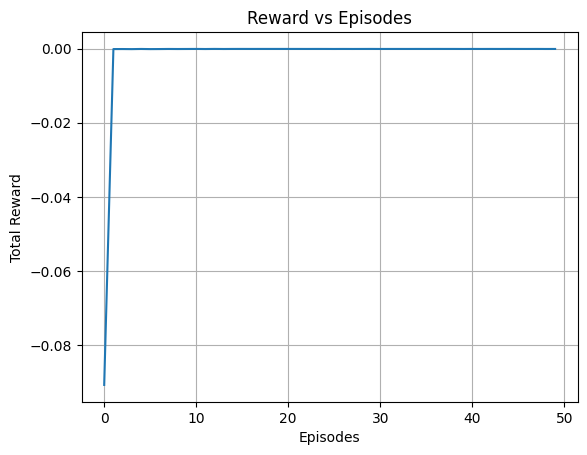

Episode 1/10, Total Reward: -9.999999999999982e-05
Episode 2/10, Total Reward: -9.999999999999982e-05
Episode 3/10, Total Reward: -9.999999999999982e-05
Episode 4/10, Total Reward: -9.999999999999982e-05
Episode 5/10, Total Reward: -9.999999999999982e-05
Episode 6/10, Total Reward: -9.999999999999982e-05
Episode 7/10, Total Reward: -9.999999999999982e-05
Episode 8/10, Total Reward: -9.999999999999982e-05
Episode 9/10, Total Reward: -9.999999999999982e-05
Episode 10/10, Total Reward: -9.999999999999982e-05
Parameters: {'learning_rate': 0.01, 'discount_factor': 0.95, 'exploration_rate': 1.0, 'exploration_decay': 0.95}, Average Reward: -9.99999999999998e-05
Testing parameters: {'learning_rate': 0.01, 'discount_factor': 0.95, 'exploration_rate': 1.0, 'exploration_decay': 0.9}
Q-table loaded from q_table_38.pkl.
Episode 1/50, Total Reward: -0.06279300000000011
Episode 2/50, Total Reward: -0.00017599999999999975
Episode 3/50, Total Reward: -0.00017199999999999974
Episode 4/50, Total Reward: 

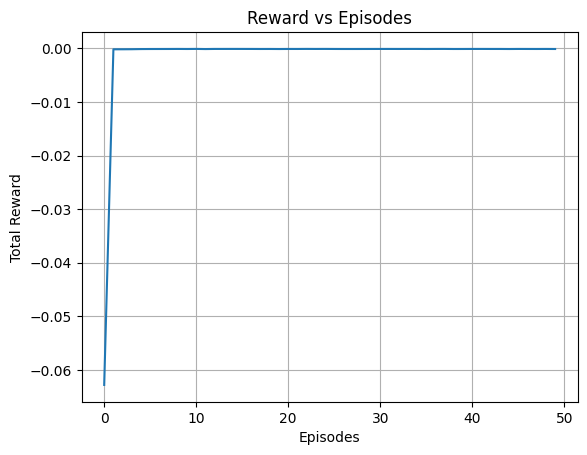

Episode 1/10, Total Reward: -9.999999999999982e-05
Episode 2/10, Total Reward: -9.999999999999982e-05
Episode 3/10, Total Reward: -9.999999999999982e-05
Episode 4/10, Total Reward: -9.999999999999982e-05
Episode 5/10, Total Reward: -9.999999999999982e-05
Episode 6/10, Total Reward: -9.999999999999982e-05
Episode 7/10, Total Reward: -9.999999999999982e-05
Episode 8/10, Total Reward: -9.999999999999982e-05
Episode 9/10, Total Reward: -9.999999999999982e-05
Episode 10/10, Total Reward: -9.999999999999982e-05
Parameters: {'learning_rate': 0.01, 'discount_factor': 0.95, 'exploration_rate': 1.0, 'exploration_decay': 0.9}, Average Reward: -9.99999999999998e-05
Testing parameters: {'learning_rate': 0.01, 'discount_factor': 0.95, 'exploration_rate': 0.5, 'exploration_decay': 0.99}
Q-table loaded from q_table_39.pkl.
Episode 1/50, Total Reward: -0.14014100000000004
Episode 2/50, Total Reward: -0.09432700000000006
Episode 3/50, Total Reward: -0.00018999999999999977
Episode 4/50, Total Reward: -0.

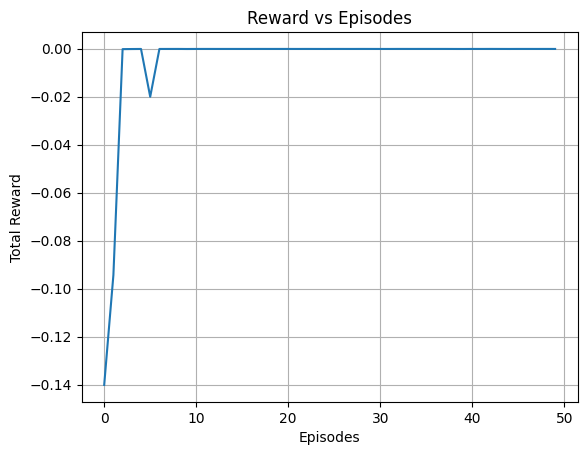

Episode 1/10, Total Reward: -9.999999999999982e-05
Episode 2/10, Total Reward: -9.999999999999982e-05
Episode 3/10, Total Reward: -9.999999999999982e-05
Episode 4/10, Total Reward: -9.999999999999982e-05
Episode 5/10, Total Reward: -9.999999999999982e-05
Episode 6/10, Total Reward: -9.999999999999982e-05
Episode 7/10, Total Reward: -9.999999999999982e-05
Episode 8/10, Total Reward: -9.999999999999982e-05
Episode 9/10, Total Reward: -9.999999999999982e-05
Episode 10/10, Total Reward: -9.999999999999982e-05
Parameters: {'learning_rate': 0.01, 'discount_factor': 0.95, 'exploration_rate': 0.5, 'exploration_decay': 0.99}, Average Reward: -9.99999999999998e-05
Testing parameters: {'learning_rate': 0.01, 'discount_factor': 0.95, 'exploration_rate': 0.5, 'exploration_decay': 0.95}
Q-table loaded from q_table_40.pkl.
Episode 1/50, Total Reward: -0.0656330000000001
Episode 2/50, Total Reward: -0.00015699999999999978
Episode 3/50, Total Reward: -0.00014899999999999977
Episode 4/50, Total Reward: 

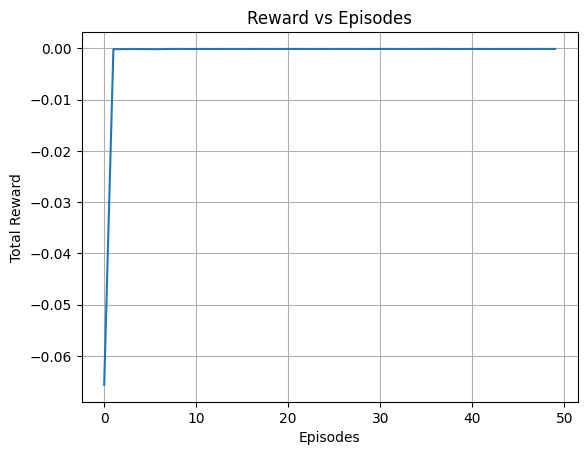

Episode 1/10, Total Reward: -0.00010099999999999981
Episode 2/10, Total Reward: -0.00010099999999999981
Episode 3/10, Total Reward: -0.00010099999999999981
Episode 4/10, Total Reward: -0.00010099999999999981
Episode 5/10, Total Reward: -0.00010099999999999981
Episode 6/10, Total Reward: -0.00010099999999999981
Episode 7/10, Total Reward: -0.00010099999999999981
Episode 8/10, Total Reward: -0.00010099999999999981
Episode 9/10, Total Reward: -0.00010099999999999981
Episode 10/10, Total Reward: -0.00010099999999999981
Parameters: {'learning_rate': 0.01, 'discount_factor': 0.95, 'exploration_rate': 0.5, 'exploration_decay': 0.95}, Average Reward: -0.00010099999999999981
Testing parameters: {'learning_rate': 0.01, 'discount_factor': 0.95, 'exploration_rate': 0.5, 'exploration_decay': 0.9}
Q-table loaded from q_table_41.pkl.
Episode 1/50, Total Reward: -0.039068000000000096
Episode 2/50, Total Reward: -0.00015399999999999976
Episode 3/50, Total Reward: -0.00018499999999999975
Episode 4/50, T

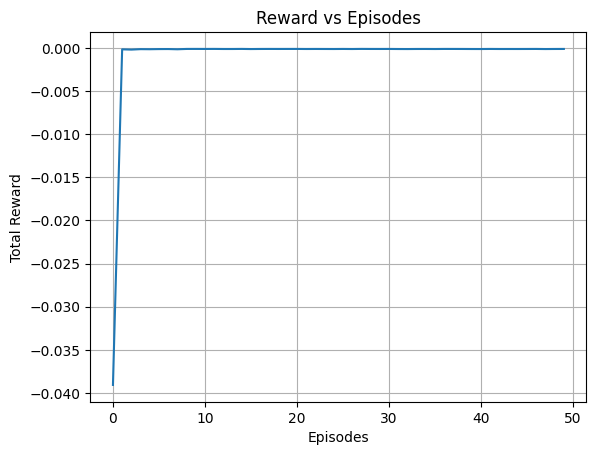

Episode 1/10, Total Reward: -0.00010099999999999981
Episode 2/10, Total Reward: -0.00010099999999999981
Episode 3/10, Total Reward: -0.00010099999999999981
Episode 4/10, Total Reward: -0.00010099999999999981
Episode 5/10, Total Reward: -0.00010099999999999981
Episode 6/10, Total Reward: -0.00010099999999999981
Episode 7/10, Total Reward: -0.00010099999999999981
Episode 8/10, Total Reward: -0.00010099999999999981
Episode 9/10, Total Reward: -0.00010099999999999981
Episode 10/10, Total Reward: -0.00010099999999999981
Parameters: {'learning_rate': 0.01, 'discount_factor': 0.95, 'exploration_rate': 0.5, 'exploration_decay': 0.9}, Average Reward: -0.00010099999999999981
Testing parameters: {'learning_rate': 0.01, 'discount_factor': 0.95, 'exploration_rate': 0.1, 'exploration_decay': 0.99}
Q-table loaded from q_table_42.pkl.
Episode 1/50, Total Reward: -0.006872000000000012
Episode 2/50, Total Reward: -0.0001499999999999998
Episode 3/50, Total Reward: -0.00015399999999999976
Episode 4/50, To

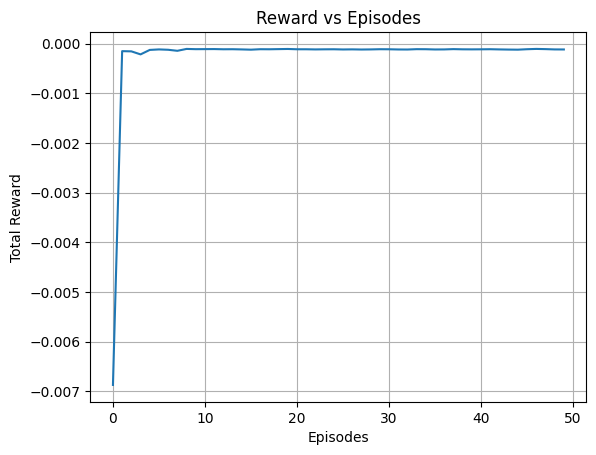

Episode 1/10, Total Reward: -9.999999999999982e-05
Episode 2/10, Total Reward: -9.999999999999982e-05
Episode 3/10, Total Reward: -9.999999999999982e-05
Episode 4/10, Total Reward: -9.999999999999982e-05
Episode 5/10, Total Reward: -9.999999999999982e-05
Episode 6/10, Total Reward: -9.999999999999982e-05
Episode 7/10, Total Reward: -9.999999999999982e-05
Episode 8/10, Total Reward: -9.999999999999982e-05
Episode 9/10, Total Reward: -9.999999999999982e-05
Episode 10/10, Total Reward: -9.999999999999982e-05
Parameters: {'learning_rate': 0.01, 'discount_factor': 0.95, 'exploration_rate': 0.1, 'exploration_decay': 0.99}, Average Reward: -9.99999999999998e-05
Testing parameters: {'learning_rate': 0.01, 'discount_factor': 0.95, 'exploration_rate': 0.1, 'exploration_decay': 0.95}
Q-table loaded from q_table_43.pkl.
Episode 1/50, Total Reward: -0.00015899999999999974
Episode 2/50, Total Reward: -0.0001319999999999998
Episode 3/50, Total Reward: -0.00018499999999999978
Episode 4/50, Total Rewar

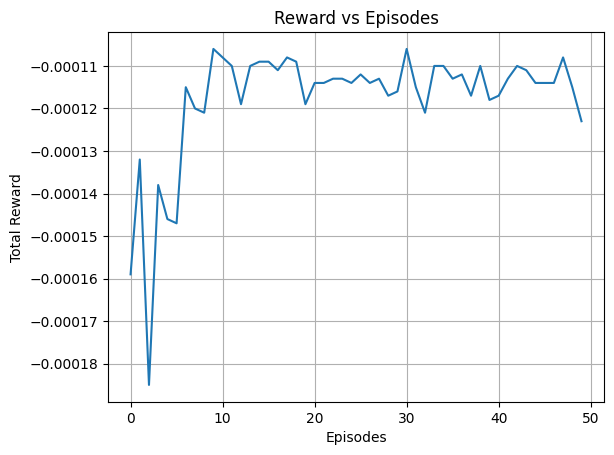

Episode 1/10, Total Reward: -0.00010099999999999981
Episode 2/10, Total Reward: -0.00010099999999999981
Episode 3/10, Total Reward: -0.00010099999999999981
Episode 4/10, Total Reward: -0.00010099999999999981
Episode 5/10, Total Reward: -0.00010099999999999981
Episode 6/10, Total Reward: -0.00010099999999999981
Episode 7/10, Total Reward: -0.00010099999999999981
Episode 8/10, Total Reward: -0.00010099999999999981
Episode 9/10, Total Reward: -0.00010099999999999981
Episode 10/10, Total Reward: -0.00010099999999999981
Parameters: {'learning_rate': 0.01, 'discount_factor': 0.95, 'exploration_rate': 0.1, 'exploration_decay': 0.95}, Average Reward: -0.00010099999999999981
Testing parameters: {'learning_rate': 0.01, 'discount_factor': 0.95, 'exploration_rate': 0.1, 'exploration_decay': 0.9}
Q-table loaded from q_table_44.pkl.
Episode 1/50, Total Reward: -0.00016899999999999974
Episode 2/50, Total Reward: -0.00011799999999999979
Episode 3/50, Total Reward: -0.00020399999999999973
Episode 4/50,

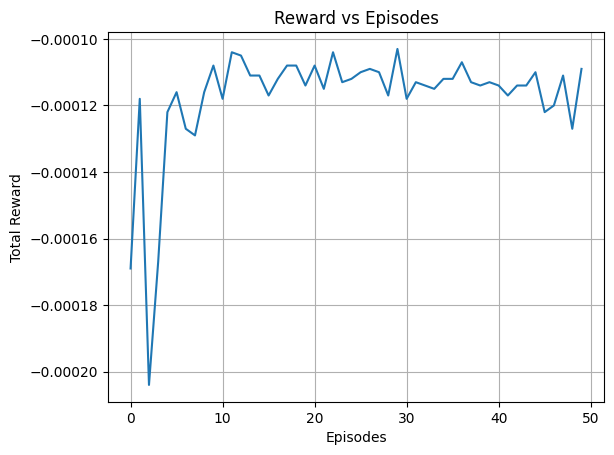

Episode 1/10, Total Reward: -9.999999999999982e-05
Episode 2/10, Total Reward: -9.999999999999982e-05
Episode 3/10, Total Reward: -9.999999999999982e-05
Episode 4/10, Total Reward: -9.999999999999982e-05
Episode 5/10, Total Reward: -9.999999999999982e-05
Episode 6/10, Total Reward: -9.999999999999982e-05
Episode 7/10, Total Reward: -9.999999999999982e-05
Episode 8/10, Total Reward: -9.999999999999982e-05
Episode 9/10, Total Reward: -9.999999999999982e-05
Episode 10/10, Total Reward: -9.999999999999982e-05
Parameters: {'learning_rate': 0.01, 'discount_factor': 0.95, 'exploration_rate': 0.1, 'exploration_decay': 0.9}, Average Reward: -9.99999999999998e-05
Testing parameters: {'learning_rate': 0.01, 'discount_factor': 0.99, 'exploration_rate': 1.0, 'exploration_decay': 0.99}
Q-table loaded from q_table_45.pkl.
Episode 1/50, Total Reward: -0.12351400000000008
Episode 2/50, Total Reward: -0.03985000000000007
Episode 3/50, Total Reward: -0.0872870000000001
Episode 4/50, Total Reward: -0.0001

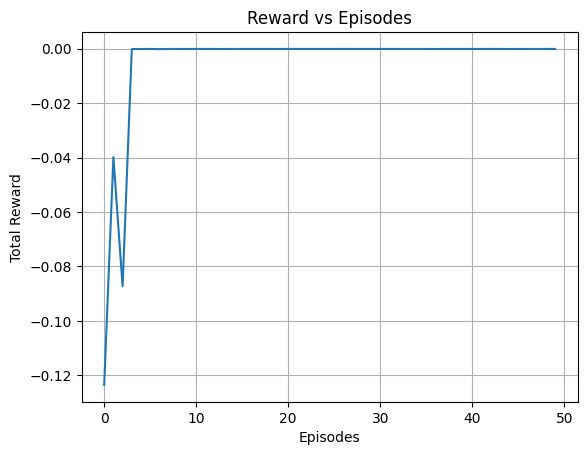

Episode 1/10, Total Reward: -0.0001239999999999998
Episode 2/10, Total Reward: -0.0001239999999999998
Episode 3/10, Total Reward: -0.0001239999999999998
Episode 4/10, Total Reward: -0.0001239999999999998
Episode 5/10, Total Reward: -0.0001239999999999998
Episode 6/10, Total Reward: -0.0001239999999999998
Episode 7/10, Total Reward: -0.0001239999999999998
Episode 8/10, Total Reward: -0.0001239999999999998
Episode 9/10, Total Reward: -0.0001239999999999998
Episode 10/10, Total Reward: -0.0001239999999999998
Parameters: {'learning_rate': 0.01, 'discount_factor': 0.99, 'exploration_rate': 1.0, 'exploration_decay': 0.99}, Average Reward: -0.0001239999999999998
Testing parameters: {'learning_rate': 0.01, 'discount_factor': 0.99, 'exploration_rate': 1.0, 'exploration_decay': 0.95}
Q-table loaded from q_table_46.pkl.
Episode 1/50, Total Reward: -0.00018099999999999976
Episode 2/50, Total Reward: -0.00015399999999999976
Episode 3/50, Total Reward: -0.00017799999999999977
Episode 4/50, Total Rew

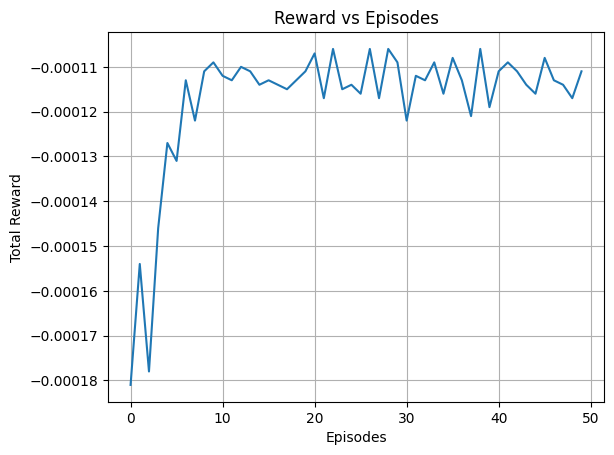

Episode 1/10, Total Reward: -0.00014999999999999974
Episode 2/10, Total Reward: -0.00014999999999999974
Episode 3/10, Total Reward: -0.00014999999999999974
Episode 4/10, Total Reward: -0.00014999999999999974
Episode 5/10, Total Reward: -0.00014999999999999974
Episode 6/10, Total Reward: -0.00014999999999999974
Episode 7/10, Total Reward: -0.00014999999999999974
Episode 8/10, Total Reward: -0.00014999999999999974
Episode 9/10, Total Reward: -0.00014999999999999974
Episode 10/10, Total Reward: -0.00014999999999999974
Parameters: {'learning_rate': 0.01, 'discount_factor': 0.99, 'exploration_rate': 1.0, 'exploration_decay': 0.95}, Average Reward: -0.00014999999999999974
Testing parameters: {'learning_rate': 0.01, 'discount_factor': 0.99, 'exploration_rate': 1.0, 'exploration_decay': 0.9}
Q-table loaded from q_table_47.pkl.
Episode 1/50, Total Reward: -0.02378200000000006
Episode 2/50, Total Reward: -0.00011599999999999982
Episode 3/50, Total Reward: -0.00019799999999999974
Episode 4/50, To

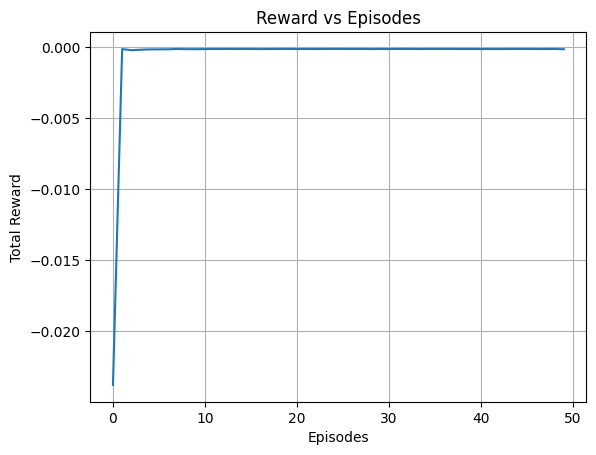

Episode 1/10, Total Reward: -9.999999999999982e-05
Episode 2/10, Total Reward: -9.999999999999982e-05
Episode 3/10, Total Reward: -9.999999999999982e-05
Episode 4/10, Total Reward: -9.999999999999982e-05
Episode 5/10, Total Reward: -9.999999999999982e-05
Episode 6/10, Total Reward: -9.999999999999982e-05
Episode 7/10, Total Reward: -9.999999999999982e-05
Episode 8/10, Total Reward: -9.999999999999982e-05
Episode 9/10, Total Reward: -9.999999999999982e-05
Episode 10/10, Total Reward: -9.999999999999982e-05
Parameters: {'learning_rate': 0.01, 'discount_factor': 0.99, 'exploration_rate': 1.0, 'exploration_decay': 0.9}, Average Reward: -9.99999999999998e-05
Testing parameters: {'learning_rate': 0.01, 'discount_factor': 0.99, 'exploration_rate': 0.5, 'exploration_decay': 0.99}
Q-table loaded from q_table_48.pkl.
Episode 1/50, Total Reward: -0.19004200000000004
Episode 2/50, Total Reward: -0.00018099999999999982
Episode 3/50, Total Reward: -0.00015699999999999975
Episode 4/50, Total Reward: 

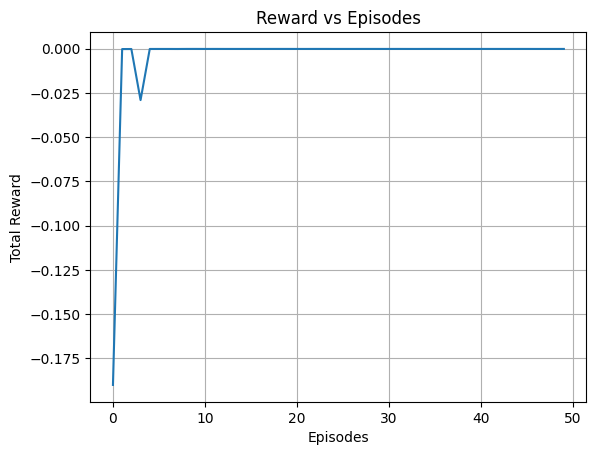

Episode 1/10, Total Reward: -0.00010099999999999981
Episode 2/10, Total Reward: -0.00010099999999999981
Episode 3/10, Total Reward: -0.00010099999999999981
Episode 4/10, Total Reward: -0.00010099999999999981
Episode 5/10, Total Reward: -0.00010099999999999981
Episode 6/10, Total Reward: -0.00010099999999999981
Episode 7/10, Total Reward: -0.00010099999999999981
Episode 8/10, Total Reward: -0.00010099999999999981
Episode 9/10, Total Reward: -0.00010099999999999981
Episode 10/10, Total Reward: -0.00010099999999999981
Parameters: {'learning_rate': 0.01, 'discount_factor': 0.99, 'exploration_rate': 0.5, 'exploration_decay': 0.99}, Average Reward: -0.00010099999999999981
Testing parameters: {'learning_rate': 0.01, 'discount_factor': 0.99, 'exploration_rate': 0.5, 'exploration_decay': 0.95}
Q-table loaded from q_table_49.pkl.
Episode 1/50, Total Reward: -0.019625000000000038
Episode 2/50, Total Reward: -0.00011899999999999979
Episode 3/50, Total Reward: -0.00020299999999999973
Episode 4/50, 

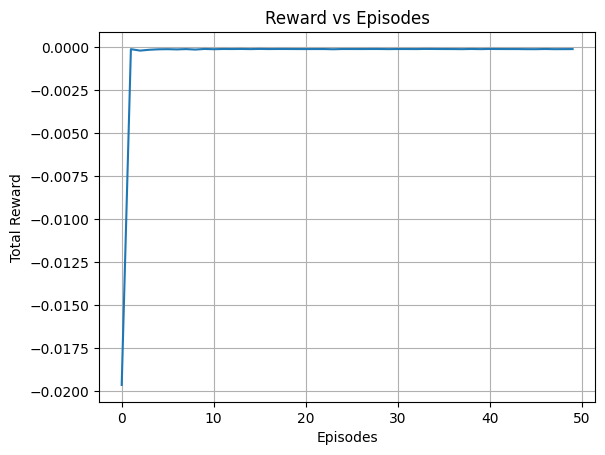

Episode 1/10, Total Reward: -9.999999999999982e-05
Episode 2/10, Total Reward: -9.999999999999982e-05
Episode 3/10, Total Reward: -9.999999999999982e-05
Episode 4/10, Total Reward: -9.999999999999982e-05
Episode 5/10, Total Reward: -9.999999999999982e-05
Episode 6/10, Total Reward: -9.999999999999982e-05
Episode 7/10, Total Reward: -9.999999999999982e-05
Episode 8/10, Total Reward: -9.999999999999982e-05
Episode 9/10, Total Reward: -9.999999999999982e-05
Episode 10/10, Total Reward: -9.999999999999982e-05
Parameters: {'learning_rate': 0.01, 'discount_factor': 0.99, 'exploration_rate': 0.5, 'exploration_decay': 0.95}, Average Reward: -9.99999999999998e-05
Testing parameters: {'learning_rate': 0.01, 'discount_factor': 0.99, 'exploration_rate': 0.5, 'exploration_decay': 0.9}
Q-table loaded from q_table_50.pkl.
Episode 1/50, Total Reward: -0.00012999999999999977
Episode 2/50, Total Reward: -0.00014199999999999977
Episode 3/50, Total Reward: -0.00015299999999999976
Episode 4/50, Total Rewar

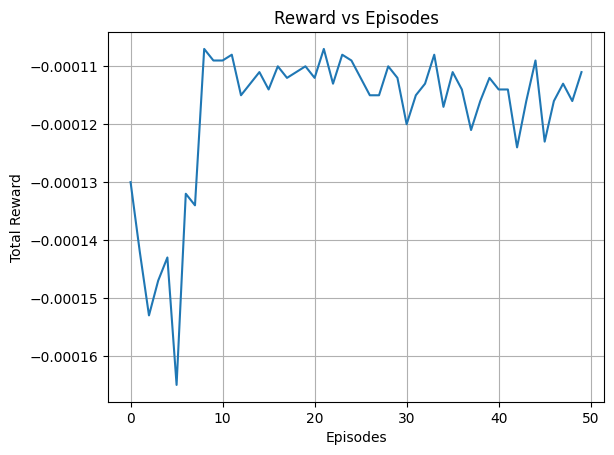

Episode 1/10, Total Reward: -0.00010099999999999981
Episode 2/10, Total Reward: -0.00010099999999999981
Episode 3/10, Total Reward: -0.00010099999999999981
Episode 4/10, Total Reward: -0.00010099999999999981
Episode 5/10, Total Reward: -0.00010099999999999981
Episode 6/10, Total Reward: -0.00010099999999999981
Episode 7/10, Total Reward: -0.00010099999999999981
Episode 8/10, Total Reward: -0.00010099999999999981
Episode 9/10, Total Reward: -0.00010099999999999981
Episode 10/10, Total Reward: -0.00010099999999999981
Parameters: {'learning_rate': 0.01, 'discount_factor': 0.99, 'exploration_rate': 0.5, 'exploration_decay': 0.9}, Average Reward: -0.00010099999999999981
Testing parameters: {'learning_rate': 0.01, 'discount_factor': 0.99, 'exploration_rate': 0.1, 'exploration_decay': 0.99}
Q-table loaded from q_table_51.pkl.
Episode 1/50, Total Reward: -0.020217000000000016
Episode 2/50, Total Reward: -0.00016999999999999977
Episode 3/50, Total Reward: -0.00014099999999999974
Episode 4/50, T

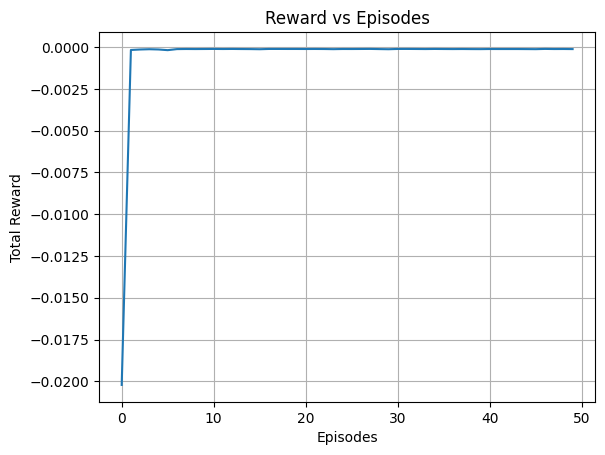

Episode 1/10, Total Reward: -0.00014499999999999976
Episode 2/10, Total Reward: -0.00014499999999999976
Episode 3/10, Total Reward: -0.00014499999999999976
Episode 4/10, Total Reward: -0.00014499999999999976
Episode 5/10, Total Reward: -0.00014499999999999976
Episode 6/10, Total Reward: -0.00014499999999999976
Episode 7/10, Total Reward: -0.00014499999999999976
Episode 8/10, Total Reward: -0.00014499999999999976
Episode 9/10, Total Reward: -0.00014499999999999976
Episode 10/10, Total Reward: -0.00014499999999999976
Parameters: {'learning_rate': 0.01, 'discount_factor': 0.99, 'exploration_rate': 0.1, 'exploration_decay': 0.99}, Average Reward: -0.00014499999999999976
Testing parameters: {'learning_rate': 0.01, 'discount_factor': 0.99, 'exploration_rate': 0.1, 'exploration_decay': 0.95}
Q-table loaded from q_table_52.pkl.
Episode 1/50, Total Reward: -0.0001319999999999998
Episode 2/50, Total Reward: -0.0001209999999999998
Episode 3/50, Total Reward: -0.0001319999999999998
Episode 4/50, T

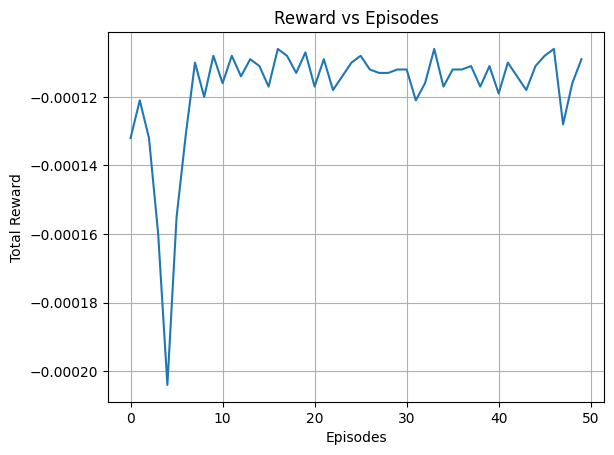

Episode 1/10, Total Reward: -0.0001029999999999998
Episode 2/10, Total Reward: -0.0001029999999999998
Episode 3/10, Total Reward: -0.0001029999999999998
Episode 4/10, Total Reward: -0.0001029999999999998
Episode 5/10, Total Reward: -0.0001029999999999998
Episode 6/10, Total Reward: -0.0001029999999999998
Episode 7/10, Total Reward: -0.0001029999999999998
Episode 8/10, Total Reward: -0.0001029999999999998
Episode 9/10, Total Reward: -0.0001029999999999998
Episode 10/10, Total Reward: -0.0001029999999999998
Parameters: {'learning_rate': 0.01, 'discount_factor': 0.99, 'exploration_rate': 0.1, 'exploration_decay': 0.95}, Average Reward: -0.00010299999999999982
Testing parameters: {'learning_rate': 0.01, 'discount_factor': 0.99, 'exploration_rate': 0.1, 'exploration_decay': 0.9}
Q-table loaded from q_table_53.pkl.
Episode 1/50, Total Reward: -0.00012299999999999982
Episode 2/50, Total Reward: -0.00016099999999999974
Episode 3/50, Total Reward: -0.0001159999999999998
Episode 4/50, Total Rewa

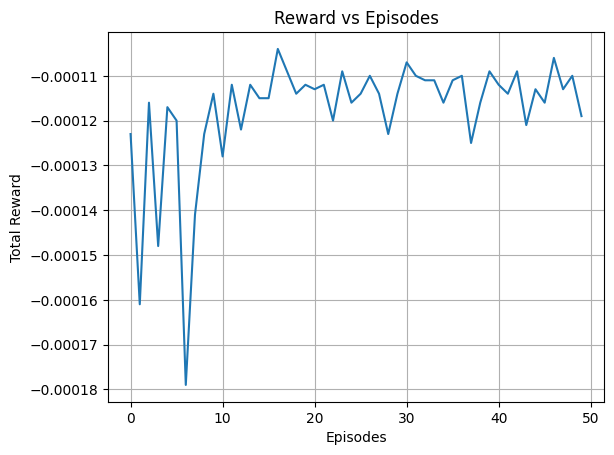

Episode 1/10, Total Reward: -9.999999999999982e-05
Episode 2/10, Total Reward: -9.999999999999982e-05
Episode 3/10, Total Reward: -9.999999999999982e-05
Episode 4/10, Total Reward: -9.999999999999982e-05
Episode 5/10, Total Reward: -9.999999999999982e-05
Episode 6/10, Total Reward: -9.999999999999982e-05
Episode 7/10, Total Reward: -9.999999999999982e-05
Episode 8/10, Total Reward: -9.999999999999982e-05
Episode 9/10, Total Reward: -9.999999999999982e-05
Episode 10/10, Total Reward: -9.999999999999982e-05
Parameters: {'learning_rate': 0.01, 'discount_factor': 0.99, 'exploration_rate': 0.1, 'exploration_decay': 0.9}, Average Reward: -9.99999999999998e-05
Testing parameters: {'learning_rate': 0.001, 'discount_factor': 0.9, 'exploration_rate': 1.0, 'exploration_decay': 0.99}
Q-table loaded from q_table_54.pkl.
Episode 1/50, Total Reward: -0.3918439999999999
Episode 2/50, Total Reward: -0.04518300000000011
Episode 3/50, Total Reward: -0.170358
Episode 4/50, Total Reward: -0.000185999999999

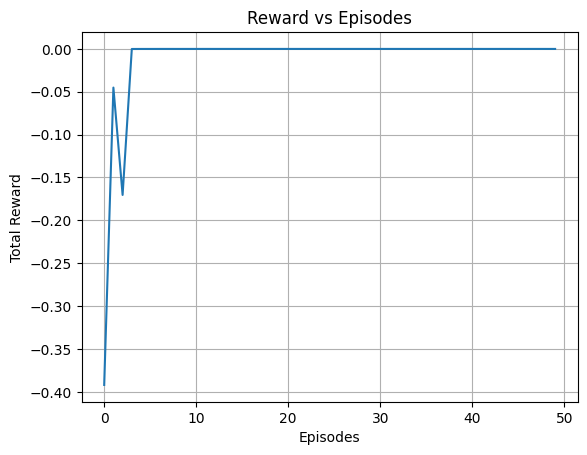

Episode 1/10, Total Reward: -9.999999999999982e-05
Episode 2/10, Total Reward: -9.999999999999982e-05
Episode 3/10, Total Reward: -9.999999999999982e-05
Episode 4/10, Total Reward: -9.999999999999982e-05
Episode 5/10, Total Reward: -9.999999999999982e-05
Episode 6/10, Total Reward: -9.999999999999982e-05
Episode 7/10, Total Reward: -9.999999999999982e-05
Episode 8/10, Total Reward: -9.999999999999982e-05
Episode 9/10, Total Reward: -9.999999999999982e-05
Episode 10/10, Total Reward: -9.999999999999982e-05
Parameters: {'learning_rate': 0.001, 'discount_factor': 0.9, 'exploration_rate': 1.0, 'exploration_decay': 0.99}, Average Reward: -9.99999999999998e-05
Testing parameters: {'learning_rate': 0.001, 'discount_factor': 0.9, 'exploration_rate': 1.0, 'exploration_decay': 0.95}
Q-table loaded from q_table_55.pkl.
Episode 1/50, Total Reward: -0.1809320000000001
Episode 2/50, Total Reward: -0.00019999999999999977
Episode 3/50, Total Reward: -0.00013599999999999978
Episode 4/50, Total Reward: 

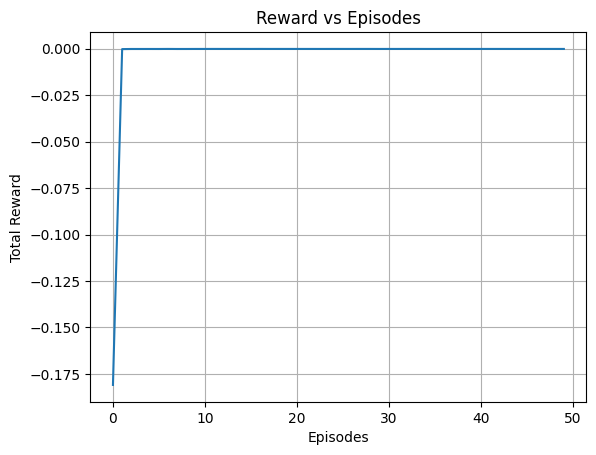

Episode 1/10, Total Reward: -0.00014599999999999975
Episode 2/10, Total Reward: -0.00014599999999999975
Episode 3/10, Total Reward: -0.00014599999999999975
Episode 4/10, Total Reward: -0.00014599999999999975
Episode 5/10, Total Reward: -0.00014599999999999975
Episode 6/10, Total Reward: -0.00014599999999999975
Episode 7/10, Total Reward: -0.00014599999999999975
Episode 8/10, Total Reward: -0.00014599999999999975
Episode 9/10, Total Reward: -0.00014599999999999975
Episode 10/10, Total Reward: -0.00014599999999999975
Parameters: {'learning_rate': 0.001, 'discount_factor': 0.9, 'exploration_rate': 1.0, 'exploration_decay': 0.95}, Average Reward: -0.00014599999999999978
Testing parameters: {'learning_rate': 0.001, 'discount_factor': 0.9, 'exploration_rate': 1.0, 'exploration_decay': 0.9}
Q-table loaded from q_table_56.pkl.
Episode 1/50, Total Reward: -0.013734999999999949
Episode 2/50, Total Reward: -0.0001229999999999998
Episode 3/50, Total Reward: -0.00012799999999999978
Episode 4/50, To

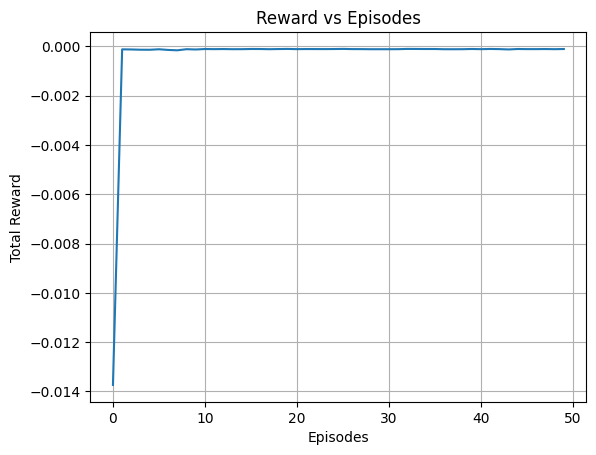

Episode 1/10, Total Reward: -9.999999999999982e-05
Episode 2/10, Total Reward: -9.999999999999982e-05
Episode 3/10, Total Reward: -9.999999999999982e-05
Episode 4/10, Total Reward: -9.999999999999982e-05
Episode 5/10, Total Reward: -9.999999999999982e-05
Episode 6/10, Total Reward: -9.999999999999982e-05
Episode 7/10, Total Reward: -9.999999999999982e-05
Episode 8/10, Total Reward: -9.999999999999982e-05
Episode 9/10, Total Reward: -9.999999999999982e-05
Episode 10/10, Total Reward: -9.999999999999982e-05
Parameters: {'learning_rate': 0.001, 'discount_factor': 0.9, 'exploration_rate': 1.0, 'exploration_decay': 0.9}, Average Reward: -9.99999999999998e-05
Testing parameters: {'learning_rate': 0.001, 'discount_factor': 0.9, 'exploration_rate': 0.5, 'exploration_decay': 0.99}
Q-table loaded from q_table_57.pkl.
Episode 1/50, Total Reward: -0.043118000000000045
Episode 2/50, Total Reward: -0.0001399999999999998
Episode 3/50, Total Reward: -0.019483000000000014
Episode 4/50, Total Reward: -0

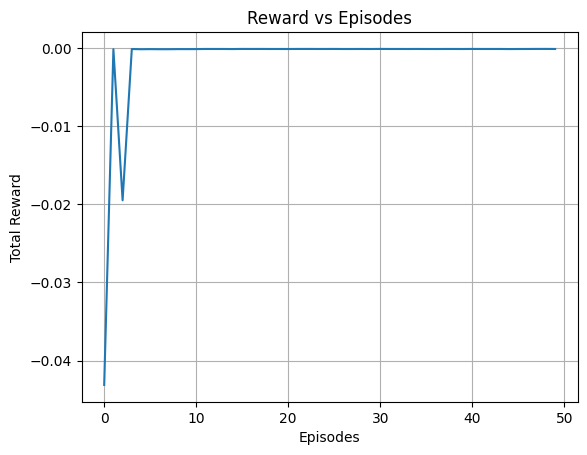

Episode 1/10, Total Reward: -9.999999999999982e-05
Episode 2/10, Total Reward: -9.999999999999982e-05
Episode 3/10, Total Reward: -9.999999999999982e-05
Episode 4/10, Total Reward: -9.999999999999982e-05
Episode 5/10, Total Reward: -9.999999999999982e-05
Episode 6/10, Total Reward: -9.999999999999982e-05
Episode 7/10, Total Reward: -9.999999999999982e-05
Episode 8/10, Total Reward: -9.999999999999982e-05
Episode 9/10, Total Reward: -9.999999999999982e-05
Episode 10/10, Total Reward: -9.999999999999982e-05
Parameters: {'learning_rate': 0.001, 'discount_factor': 0.9, 'exploration_rate': 0.5, 'exploration_decay': 0.99}, Average Reward: -9.99999999999998e-05
Testing parameters: {'learning_rate': 0.001, 'discount_factor': 0.9, 'exploration_rate': 0.5, 'exploration_decay': 0.95}
Q-table loaded from q_table_58.pkl.
Episode 1/50, Total Reward: -0.026362000000000017
Episode 2/50, Total Reward: -0.00013899999999999977
Episode 3/50, Total Reward: -0.00017499999999999978
Episode 4/50, Total Reward

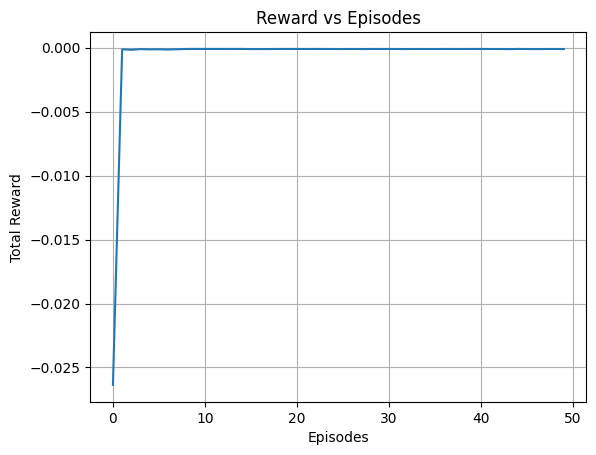

Episode 1/10, Total Reward: -9.999999999999982e-05
Episode 2/10, Total Reward: -9.999999999999982e-05
Episode 3/10, Total Reward: -9.999999999999982e-05
Episode 4/10, Total Reward: -9.999999999999982e-05
Episode 5/10, Total Reward: -9.999999999999982e-05
Episode 6/10, Total Reward: -9.999999999999982e-05
Episode 7/10, Total Reward: -9.999999999999982e-05
Episode 8/10, Total Reward: -9.999999999999982e-05
Episode 9/10, Total Reward: -9.999999999999982e-05
Episode 10/10, Total Reward: -9.999999999999982e-05
Parameters: {'learning_rate': 0.001, 'discount_factor': 0.9, 'exploration_rate': 0.5, 'exploration_decay': 0.95}, Average Reward: -9.99999999999998e-05
Testing parameters: {'learning_rate': 0.001, 'discount_factor': 0.9, 'exploration_rate': 0.5, 'exploration_decay': 0.9}
Q-table loaded from q_table_59.pkl.
Episode 1/50, Total Reward: -0.006846000000000015
Episode 2/50, Total Reward: -0.0001739999999999997
Episode 3/50, Total Reward: -0.0001799999999999998
Episode 4/50, Total Reward: -

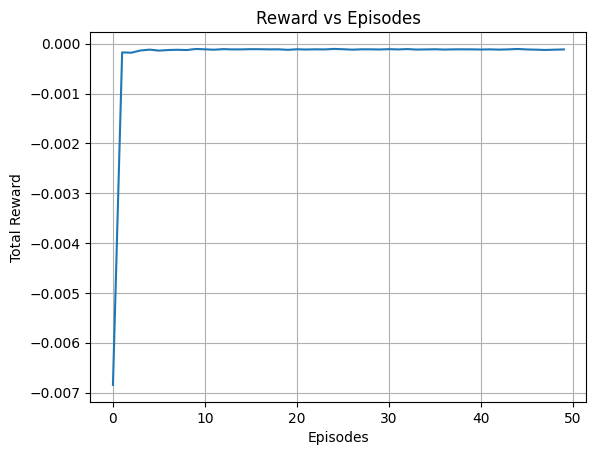

Episode 1/10, Total Reward: -9.999999999999982e-05
Episode 2/10, Total Reward: -9.999999999999982e-05
Episode 3/10, Total Reward: -9.999999999999982e-05
Episode 4/10, Total Reward: -9.999999999999982e-05
Episode 5/10, Total Reward: -9.999999999999982e-05
Episode 6/10, Total Reward: -9.999999999999982e-05
Episode 7/10, Total Reward: -9.999999999999982e-05
Episode 8/10, Total Reward: -9.999999999999982e-05
Episode 9/10, Total Reward: -9.999999999999982e-05
Episode 10/10, Total Reward: -9.999999999999982e-05
Parameters: {'learning_rate': 0.001, 'discount_factor': 0.9, 'exploration_rate': 0.5, 'exploration_decay': 0.9}, Average Reward: -9.99999999999998e-05
Testing parameters: {'learning_rate': 0.001, 'discount_factor': 0.9, 'exploration_rate': 0.1, 'exploration_decay': 0.99}
Q-table loaded from q_table_60.pkl.
Episode 1/50, Total Reward: -0.020242999999999997
Episode 2/50, Total Reward: -0.00018299999999999973
Episode 3/50, Total Reward: -0.00015899999999999977
Episode 4/50, Total Reward:

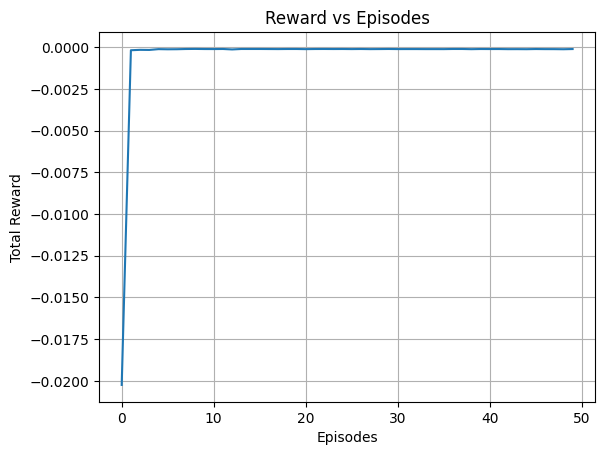

Episode 1/10, Total Reward: -0.0001039999999999998
Episode 2/10, Total Reward: -0.0001039999999999998
Episode 3/10, Total Reward: -0.0001039999999999998
Episode 4/10, Total Reward: -0.0001039999999999998
Episode 5/10, Total Reward: -0.0001039999999999998
Episode 6/10, Total Reward: -0.0001039999999999998
Episode 7/10, Total Reward: -0.0001039999999999998
Episode 8/10, Total Reward: -0.0001039999999999998
Episode 9/10, Total Reward: -0.0001039999999999998
Episode 10/10, Total Reward: -0.0001039999999999998
Parameters: {'learning_rate': 0.001, 'discount_factor': 0.9, 'exploration_rate': 0.1, 'exploration_decay': 0.99}, Average Reward: -0.00010399999999999979
Testing parameters: {'learning_rate': 0.001, 'discount_factor': 0.9, 'exploration_rate': 0.1, 'exploration_decay': 0.95}
Q-table loaded from q_table_61.pkl.
Episode 1/50, Total Reward: -0.019735000000000023
Episode 2/50, Total Reward: -0.00015199999999999976
Episode 3/50, Total Reward: -0.00016899999999999977
Episode 4/50, Total Rewa

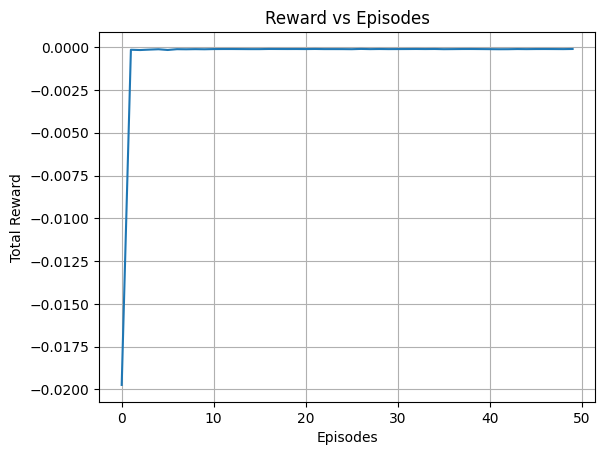

Episode 1/10, Total Reward: -9.999999999999982e-05
Episode 2/10, Total Reward: -9.999999999999982e-05
Episode 3/10, Total Reward: -9.999999999999982e-05
Episode 4/10, Total Reward: -9.999999999999982e-05
Episode 5/10, Total Reward: -9.999999999999982e-05
Episode 6/10, Total Reward: -9.999999999999982e-05
Episode 7/10, Total Reward: -9.999999999999982e-05
Episode 8/10, Total Reward: -9.999999999999982e-05
Episode 9/10, Total Reward: -9.999999999999982e-05
Episode 10/10, Total Reward: -9.999999999999982e-05
Parameters: {'learning_rate': 0.001, 'discount_factor': 0.9, 'exploration_rate': 0.1, 'exploration_decay': 0.95}, Average Reward: -9.99999999999998e-05
Testing parameters: {'learning_rate': 0.001, 'discount_factor': 0.9, 'exploration_rate': 0.1, 'exploration_decay': 0.9}
Q-table loaded from q_table_62.pkl.
Episode 1/50, Total Reward: -0.00016299999999999976
Episode 2/50, Total Reward: -0.00016699999999999978
Episode 3/50, Total Reward: -0.00014599999999999978
Episode 4/50, Total Rewar

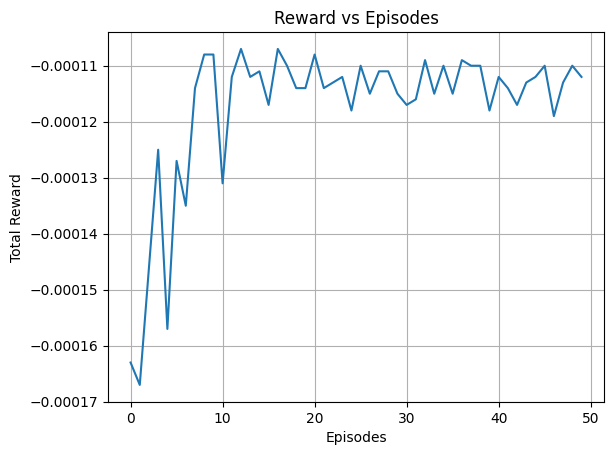

Episode 1/10, Total Reward: -0.00014999999999999974
Episode 2/10, Total Reward: -0.00014999999999999974
Episode 3/10, Total Reward: -0.00014999999999999974
Episode 4/10, Total Reward: -0.00014999999999999974
Episode 5/10, Total Reward: -0.00014999999999999974
Episode 6/10, Total Reward: -0.00014999999999999974
Episode 7/10, Total Reward: -0.00014999999999999974
Episode 8/10, Total Reward: -0.00014999999999999974
Episode 9/10, Total Reward: -0.00014999999999999974
Episode 10/10, Total Reward: -0.00014999999999999974
Parameters: {'learning_rate': 0.001, 'discount_factor': 0.9, 'exploration_rate': 0.1, 'exploration_decay': 0.9}, Average Reward: -0.00014999999999999974
Testing parameters: {'learning_rate': 0.001, 'discount_factor': 0.95, 'exploration_rate': 1.0, 'exploration_decay': 0.99}
Q-table loaded from q_table_63.pkl.
Episode 1/50, Total Reward: -0.14926800000000007
Episode 2/50, Total Reward: -0.02052400000000003
Episode 3/50, Total Reward: -0.09784600000000007
Episode 4/50, Total R

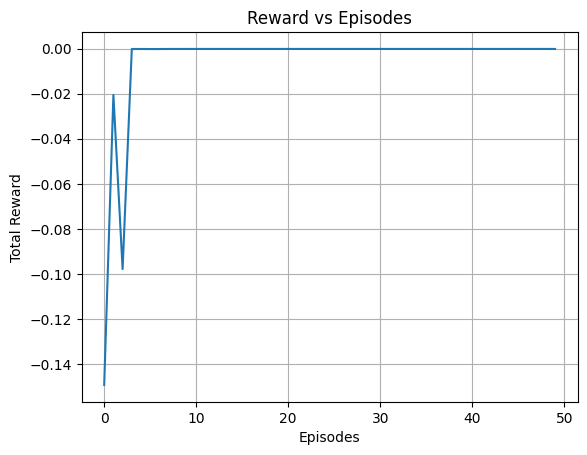

Episode 1/10, Total Reward: -9.999999999999982e-05
Episode 2/10, Total Reward: -9.999999999999982e-05
Episode 3/10, Total Reward: -9.999999999999982e-05
Episode 4/10, Total Reward: -9.999999999999982e-05
Episode 5/10, Total Reward: -9.999999999999982e-05
Episode 6/10, Total Reward: -9.999999999999982e-05
Episode 7/10, Total Reward: -9.999999999999982e-05
Episode 8/10, Total Reward: -9.999999999999982e-05
Episode 9/10, Total Reward: -9.999999999999982e-05
Episode 10/10, Total Reward: -9.999999999999982e-05
Parameters: {'learning_rate': 0.001, 'discount_factor': 0.95, 'exploration_rate': 1.0, 'exploration_decay': 0.99}, Average Reward: -9.99999999999998e-05
Testing parameters: {'learning_rate': 0.001, 'discount_factor': 0.95, 'exploration_rate': 1.0, 'exploration_decay': 0.95}
Q-table loaded from q_table_64.pkl.
Episode 1/50, Total Reward: -0.11831500000000009
Episode 2/50, Total Reward: -0.0001309999999999998
Episode 3/50, Total Reward: -0.00013399999999999981
Episode 4/50, Total Reward

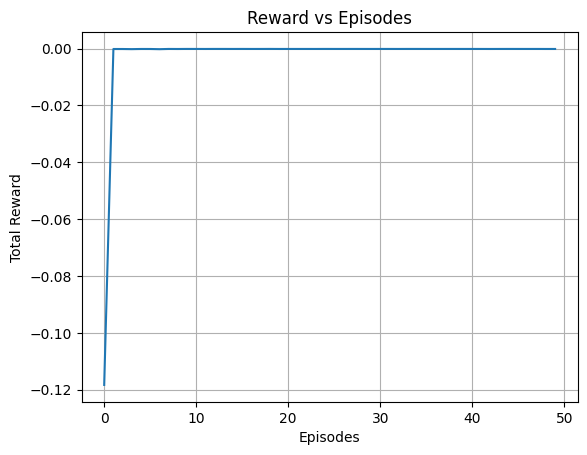

Episode 1/10, Total Reward: -0.0001199999999999998
Episode 2/10, Total Reward: -0.0001199999999999998
Episode 3/10, Total Reward: -0.0001199999999999998
Episode 4/10, Total Reward: -0.0001199999999999998
Episode 5/10, Total Reward: -0.0001199999999999998
Episode 6/10, Total Reward: -0.0001199999999999998
Episode 7/10, Total Reward: -0.0001199999999999998
Episode 8/10, Total Reward: -0.0001199999999999998
Episode 9/10, Total Reward: -0.0001199999999999998
Episode 10/10, Total Reward: -0.0001199999999999998
Parameters: {'learning_rate': 0.001, 'discount_factor': 0.95, 'exploration_rate': 1.0, 'exploration_decay': 0.95}, Average Reward: -0.00011999999999999981
Testing parameters: {'learning_rate': 0.001, 'discount_factor': 0.95, 'exploration_rate': 1.0, 'exploration_decay': 0.9}
Q-table loaded from q_table_65.pkl.
Episode 1/50, Total Reward: -0.019877000000000047
Episode 2/50, Total Reward: -0.00015099999999999977
Episode 3/50, Total Reward: -0.00014899999999999977
Episode 4/50, Total Rew

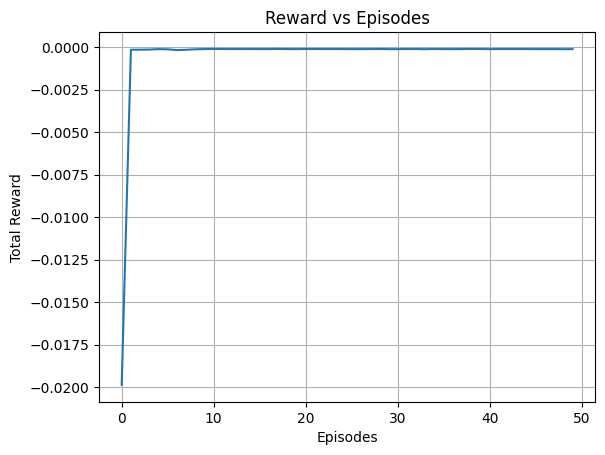

Episode 1/10, Total Reward: -0.00010099999999999981
Episode 2/10, Total Reward: -0.00010099999999999981
Episode 3/10, Total Reward: -0.00010099999999999981
Episode 4/10, Total Reward: -0.00010099999999999981
Episode 5/10, Total Reward: -0.00010099999999999981
Episode 6/10, Total Reward: -0.00010099999999999981
Episode 7/10, Total Reward: -0.00010099999999999981
Episode 8/10, Total Reward: -0.00010099999999999981
Episode 9/10, Total Reward: -0.00010099999999999981
Episode 10/10, Total Reward: -0.00010099999999999981
Parameters: {'learning_rate': 0.001, 'discount_factor': 0.95, 'exploration_rate': 1.0, 'exploration_decay': 0.9}, Average Reward: -0.00010099999999999981
Testing parameters: {'learning_rate': 0.001, 'discount_factor': 0.95, 'exploration_rate': 0.5, 'exploration_decay': 0.99}
Q-table loaded from q_table_66.pkl.
Episode 1/50, Total Reward: -0.1083810000000001
Episode 2/50, Total Reward: -0.04638500000000003
Episode 3/50, Total Reward: -0.0001549999999999998
Episode 4/50, Total

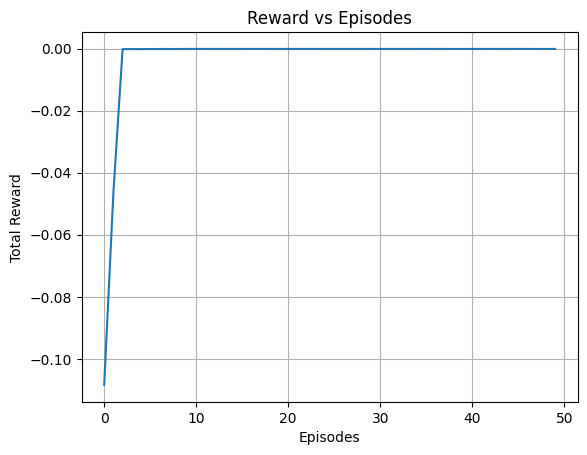

Episode 1/10, Total Reward: -9.999999999999982e-05
Episode 2/10, Total Reward: -9.999999999999982e-05
Episode 3/10, Total Reward: -9.999999999999982e-05
Episode 4/10, Total Reward: -9.999999999999982e-05
Episode 5/10, Total Reward: -9.999999999999982e-05
Episode 6/10, Total Reward: -9.999999999999982e-05
Episode 7/10, Total Reward: -9.999999999999982e-05
Episode 8/10, Total Reward: -9.999999999999982e-05
Episode 9/10, Total Reward: -9.999999999999982e-05
Episode 10/10, Total Reward: -9.999999999999982e-05
Parameters: {'learning_rate': 0.001, 'discount_factor': 0.95, 'exploration_rate': 0.5, 'exploration_decay': 0.99}, Average Reward: -9.99999999999998e-05
Testing parameters: {'learning_rate': 0.001, 'discount_factor': 0.95, 'exploration_rate': 0.5, 'exploration_decay': 0.95}
Q-table loaded from q_table_67.pkl.
Episode 1/50, Total Reward: -0.02718500000000005
Episode 2/50, Total Reward: -0.0001409999999999998
Episode 3/50, Total Reward: -0.00015399999999999973
Episode 4/50, Total Reward

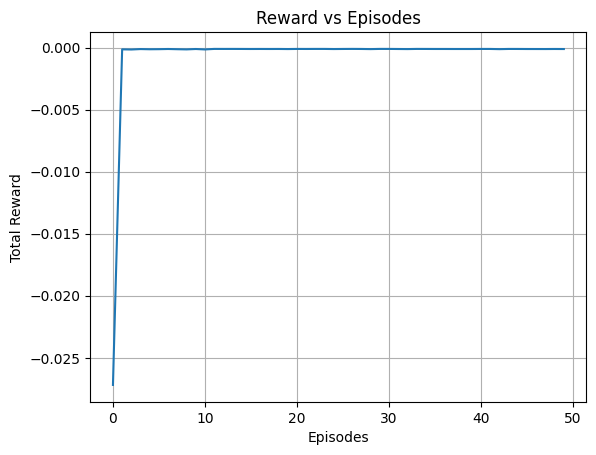

Episode 1/10, Total Reward: -9.999999999999982e-05
Episode 2/10, Total Reward: -9.999999999999982e-05
Episode 3/10, Total Reward: -9.999999999999982e-05
Episode 4/10, Total Reward: -9.999999999999982e-05
Episode 5/10, Total Reward: -9.999999999999982e-05
Episode 6/10, Total Reward: -9.999999999999982e-05
Episode 7/10, Total Reward: -9.999999999999982e-05
Episode 8/10, Total Reward: -9.999999999999982e-05
Episode 9/10, Total Reward: -9.999999999999982e-05
Episode 10/10, Total Reward: -9.999999999999982e-05
Parameters: {'learning_rate': 0.001, 'discount_factor': 0.95, 'exploration_rate': 0.5, 'exploration_decay': 0.95}, Average Reward: -9.99999999999998e-05
Testing parameters: {'learning_rate': 0.001, 'discount_factor': 0.95, 'exploration_rate': 0.5, 'exploration_decay': 0.9}
Q-table loaded from q_table_68.pkl.
Episode 1/50, Total Reward: -0.04624700000000011
Episode 2/50, Total Reward: -0.00012199999999999981
Episode 3/50, Total Reward: -0.00013599999999999978
Episode 4/50, Total Reward

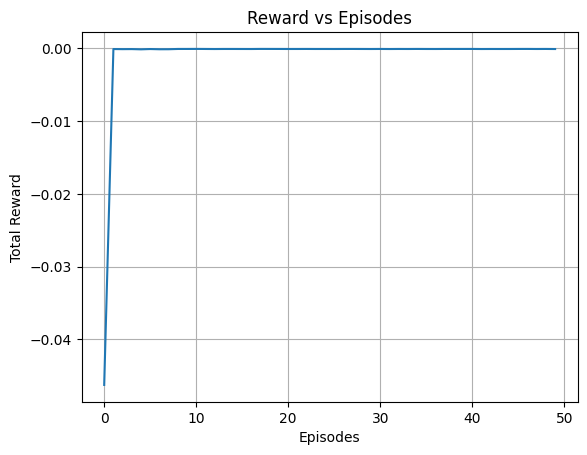

Episode 1/10, Total Reward: -0.00014799999999999975
Episode 2/10, Total Reward: -0.00014799999999999975
Episode 3/10, Total Reward: -0.00014799999999999975
Episode 4/10, Total Reward: -0.00014799999999999975
Episode 5/10, Total Reward: -0.00014799999999999975
Episode 6/10, Total Reward: -0.00014799999999999975
Episode 7/10, Total Reward: -0.00014799999999999975
Episode 8/10, Total Reward: -0.00014799999999999975
Episode 9/10, Total Reward: -0.00014799999999999975
Episode 10/10, Total Reward: -0.00014799999999999975
Parameters: {'learning_rate': 0.001, 'discount_factor': 0.95, 'exploration_rate': 0.5, 'exploration_decay': 0.9}, Average Reward: -0.00014799999999999975
Testing parameters: {'learning_rate': 0.001, 'discount_factor': 0.95, 'exploration_rate': 0.1, 'exploration_decay': 0.99}
Q-table loaded from q_table_69.pkl.
Episode 1/50, Total Reward: -0.00012599999999999978
Episode 2/50, Total Reward: -0.00017099999999999982
Episode 3/50, Total Reward: -0.00011799999999999979
Episode 4/5

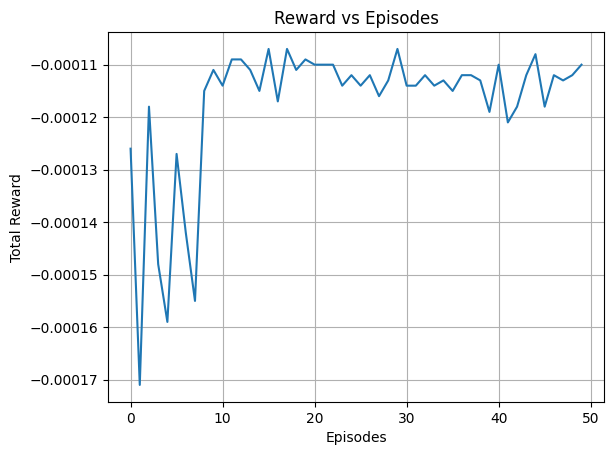

Episode 1/10, Total Reward: -9.999999999999982e-05
Episode 2/10, Total Reward: -9.999999999999982e-05
Episode 3/10, Total Reward: -9.999999999999982e-05
Episode 4/10, Total Reward: -9.999999999999982e-05
Episode 5/10, Total Reward: -9.999999999999982e-05
Episode 6/10, Total Reward: -9.999999999999982e-05
Episode 7/10, Total Reward: -9.999999999999982e-05
Episode 8/10, Total Reward: -9.999999999999982e-05
Episode 9/10, Total Reward: -9.999999999999982e-05
Episode 10/10, Total Reward: -9.999999999999982e-05
Parameters: {'learning_rate': 0.001, 'discount_factor': 0.95, 'exploration_rate': 0.1, 'exploration_decay': 0.99}, Average Reward: -9.99999999999998e-05
Testing parameters: {'learning_rate': 0.001, 'discount_factor': 0.95, 'exploration_rate': 0.1, 'exploration_decay': 0.95}
Q-table loaded from q_table_70.pkl.
Episode 1/50, Total Reward: -0.0001339999999999998
Episode 2/50, Total Reward: -0.0001519999999999997
Episode 3/50, Total Reward: -0.0001389999999999998
Episode 4/50, Total Rewar

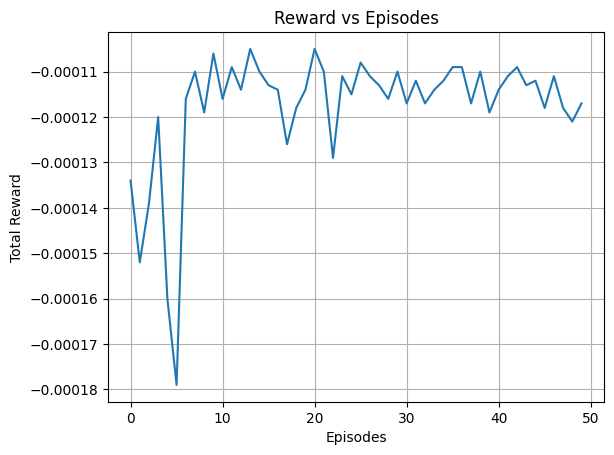

Episode 1/10, Total Reward: -0.00010099999999999981
Episode 2/10, Total Reward: -0.00010099999999999981
Episode 3/10, Total Reward: -0.00010099999999999981
Episode 4/10, Total Reward: -0.00010099999999999981
Episode 5/10, Total Reward: -0.00010099999999999981
Episode 6/10, Total Reward: -0.00010099999999999981
Episode 7/10, Total Reward: -0.00010099999999999981
Episode 8/10, Total Reward: -0.00010099999999999981
Episode 9/10, Total Reward: -0.00010099999999999981
Episode 10/10, Total Reward: -0.00010099999999999981
Parameters: {'learning_rate': 0.001, 'discount_factor': 0.95, 'exploration_rate': 0.1, 'exploration_decay': 0.95}, Average Reward: -0.00010099999999999981
Testing parameters: {'learning_rate': 0.001, 'discount_factor': 0.95, 'exploration_rate': 0.1, 'exploration_decay': 0.9}
Q-table loaded from q_table_71.pkl.
Episode 1/50, Total Reward: -0.0001439999999999998
Episode 2/50, Total Reward: -0.00011799999999999979
Episode 3/50, Total Reward: -0.00013699999999999978
Episode 4/50

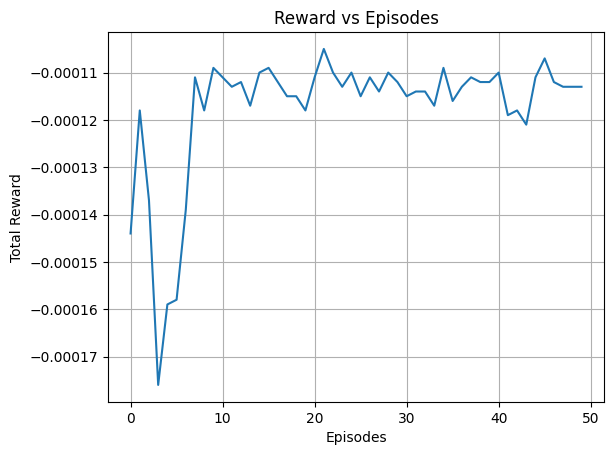

Episode 1/10, Total Reward: -9.999999999999982e-05
Episode 2/10, Total Reward: -9.999999999999982e-05
Episode 3/10, Total Reward: -9.999999999999982e-05
Episode 4/10, Total Reward: -9.999999999999982e-05
Episode 5/10, Total Reward: -9.999999999999982e-05
Episode 6/10, Total Reward: -9.999999999999982e-05
Episode 7/10, Total Reward: -9.999999999999982e-05
Episode 8/10, Total Reward: -9.999999999999982e-05
Episode 9/10, Total Reward: -9.999999999999982e-05
Episode 10/10, Total Reward: -9.999999999999982e-05
Parameters: {'learning_rate': 0.001, 'discount_factor': 0.95, 'exploration_rate': 0.1, 'exploration_decay': 0.9}, Average Reward: -9.99999999999998e-05
Testing parameters: {'learning_rate': 0.001, 'discount_factor': 0.99, 'exploration_rate': 1.0, 'exploration_decay': 0.99}
Q-table loaded from q_table_72.pkl.
Episode 1/50, Total Reward: -0.29469999999999913
Episode 2/50, Total Reward: -0.030102000000000014
Episode 3/50, Total Reward: -0.006965000000000003
Episode 4/50, Total Reward: -0

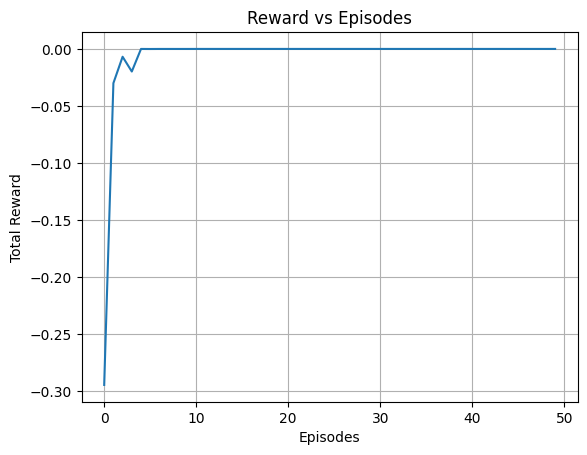

Episode 1/10, Total Reward: -9.999999999999982e-05
Episode 2/10, Total Reward: -9.999999999999982e-05
Episode 3/10, Total Reward: -9.999999999999982e-05
Episode 4/10, Total Reward: -9.999999999999982e-05
Episode 5/10, Total Reward: -9.999999999999982e-05
Episode 6/10, Total Reward: -9.999999999999982e-05
Episode 7/10, Total Reward: -9.999999999999982e-05
Episode 8/10, Total Reward: -9.999999999999982e-05
Episode 9/10, Total Reward: -9.999999999999982e-05
Episode 10/10, Total Reward: -9.999999999999982e-05
Parameters: {'learning_rate': 0.001, 'discount_factor': 0.99, 'exploration_rate': 1.0, 'exploration_decay': 0.99}, Average Reward: -9.99999999999998e-05
Testing parameters: {'learning_rate': 0.001, 'discount_factor': 0.99, 'exploration_rate': 1.0, 'exploration_decay': 0.95}
Q-table loaded from q_table_73.pkl.
Episode 1/50, Total Reward: -0.09663300000000014
Episode 2/50, Total Reward: -0.00011899999999999979
Episode 3/50, Total Reward: -0.00018299999999999976
Episode 4/50, Total Rewar

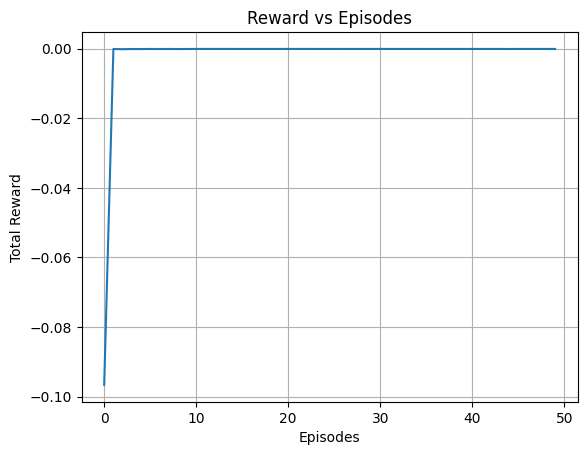

Episode 1/10, Total Reward: -0.00011099999999999981
Episode 2/10, Total Reward: -0.00011099999999999981
Episode 3/10, Total Reward: -0.00011099999999999981
Episode 4/10, Total Reward: -0.00011099999999999981
Episode 5/10, Total Reward: -0.00011099999999999981
Episode 6/10, Total Reward: -0.00011099999999999981
Episode 7/10, Total Reward: -0.00011099999999999981
Episode 8/10, Total Reward: -0.00011099999999999981
Episode 9/10, Total Reward: -0.00011099999999999981
Episode 10/10, Total Reward: -0.00011099999999999981
Parameters: {'learning_rate': 0.001, 'discount_factor': 0.99, 'exploration_rate': 1.0, 'exploration_decay': 0.95}, Average Reward: -0.00011099999999999981
Testing parameters: {'learning_rate': 0.001, 'discount_factor': 0.99, 'exploration_rate': 1.0, 'exploration_decay': 0.9}
Q-table loaded from q_table_74.pkl.
Episode 1/50, Total Reward: -0.11794300000000013
Episode 2/50, Total Reward: -0.00015399999999999979
Episode 3/50, Total Reward: -0.0001389999999999998
Episode 4/50, T

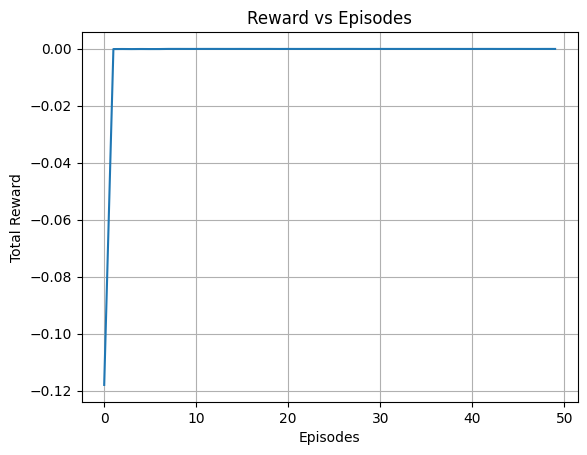

Episode 1/10, Total Reward: -0.0001239999999999998
Episode 2/10, Total Reward: -0.0001239999999999998
Episode 3/10, Total Reward: -0.0001239999999999998
Episode 4/10, Total Reward: -0.0001239999999999998
Episode 5/10, Total Reward: -0.0001239999999999998
Episode 6/10, Total Reward: -0.0001239999999999998
Episode 7/10, Total Reward: -0.0001239999999999998
Episode 8/10, Total Reward: -0.0001239999999999998
Episode 9/10, Total Reward: -0.0001239999999999998
Episode 10/10, Total Reward: -0.0001239999999999998
Parameters: {'learning_rate': 0.001, 'discount_factor': 0.99, 'exploration_rate': 1.0, 'exploration_decay': 0.9}, Average Reward: -0.0001239999999999998
Testing parameters: {'learning_rate': 0.001, 'discount_factor': 0.99, 'exploration_rate': 0.5, 'exploration_decay': 0.99}
Q-table loaded from q_table_75.pkl.
Episode 1/50, Total Reward: -0.1646520000000001
Episode 2/50, Total Reward: -0.00012899999999999977
Episode 3/50, Total Reward: -0.00015799999999999975
Episode 4/50, Total Reward

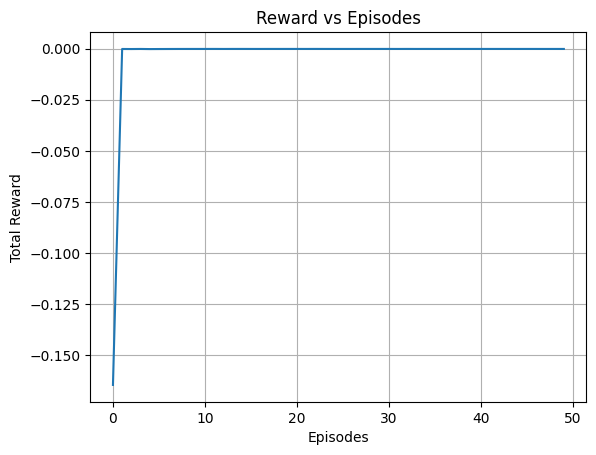

Episode 1/10, Total Reward: -9.999999999999982e-05
Episode 2/10, Total Reward: -9.999999999999982e-05
Episode 3/10, Total Reward: -9.999999999999982e-05
Episode 4/10, Total Reward: -9.999999999999982e-05
Episode 5/10, Total Reward: -9.999999999999982e-05
Episode 6/10, Total Reward: -9.999999999999982e-05
Episode 7/10, Total Reward: -9.999999999999982e-05
Episode 8/10, Total Reward: -9.999999999999982e-05
Episode 9/10, Total Reward: -9.999999999999982e-05
Episode 10/10, Total Reward: -9.999999999999982e-05
Parameters: {'learning_rate': 0.001, 'discount_factor': 0.99, 'exploration_rate': 0.5, 'exploration_decay': 0.99}, Average Reward: -9.99999999999998e-05
Testing parameters: {'learning_rate': 0.001, 'discount_factor': 0.99, 'exploration_rate': 0.5, 'exploration_decay': 0.95}
Q-table loaded from q_table_76.pkl.
Episode 1/50, Total Reward: -0.00012199999999999982
Episode 2/50, Total Reward: -0.0001369999999999998
Episode 3/50, Total Reward: -0.0001349999999999998
Episode 4/50, Total Rewa

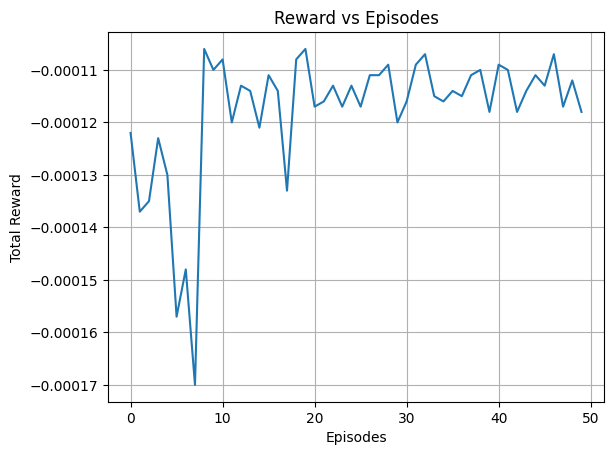

Episode 1/10, Total Reward: -0.00010099999999999981
Episode 2/10, Total Reward: -0.00010099999999999981
Episode 3/10, Total Reward: -0.00010099999999999981
Episode 4/10, Total Reward: -0.00010099999999999981
Episode 5/10, Total Reward: -0.00010099999999999981
Episode 6/10, Total Reward: -0.00010099999999999981
Episode 7/10, Total Reward: -0.00010099999999999981
Episode 8/10, Total Reward: -0.00010099999999999981
Episode 9/10, Total Reward: -0.00010099999999999981
Episode 10/10, Total Reward: -0.00010099999999999981
Parameters: {'learning_rate': 0.001, 'discount_factor': 0.99, 'exploration_rate': 0.5, 'exploration_decay': 0.95}, Average Reward: -0.00010099999999999981
Testing parameters: {'learning_rate': 0.001, 'discount_factor': 0.99, 'exploration_rate': 0.5, 'exploration_decay': 0.9}
Q-table loaded from q_table_77.pkl.
Episode 1/50, Total Reward: -0.00012599999999999978
Episode 2/50, Total Reward: -0.00014499999999999978
Episode 3/50, Total Reward: -0.00014299999999999976
Episode 4/5

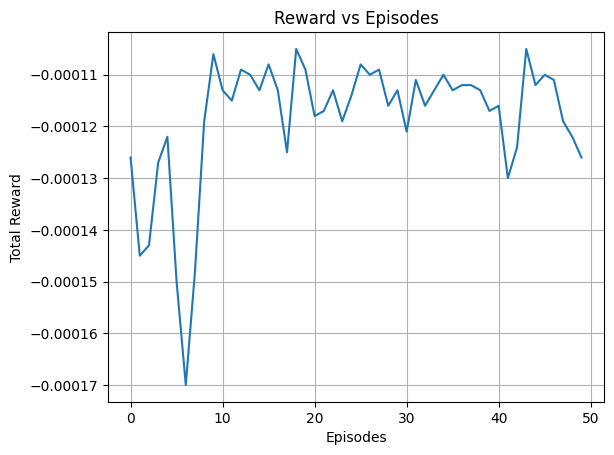

Episode 1/10, Total Reward: -0.00010099999999999981
Episode 2/10, Total Reward: -0.00010099999999999981
Episode 3/10, Total Reward: -0.00010099999999999981
Episode 4/10, Total Reward: -0.00010099999999999981
Episode 5/10, Total Reward: -0.00010099999999999981
Episode 6/10, Total Reward: -0.00010099999999999981
Episode 7/10, Total Reward: -0.00010099999999999981
Episode 8/10, Total Reward: -0.00010099999999999981
Episode 9/10, Total Reward: -0.00010099999999999981
Episode 10/10, Total Reward: -0.00010099999999999981
Parameters: {'learning_rate': 0.001, 'discount_factor': 0.99, 'exploration_rate': 0.5, 'exploration_decay': 0.9}, Average Reward: -0.00010099999999999981
Testing parameters: {'learning_rate': 0.001, 'discount_factor': 0.99, 'exploration_rate': 0.1, 'exploration_decay': 0.99}
Q-table loaded from q_table_78.pkl.
Episode 1/50, Total Reward: -0.027081000000000018
Episode 2/50, Total Reward: -0.00016499999999999978
Episode 3/50, Total Reward: -0.0002069999999999997
Episode 4/50, 

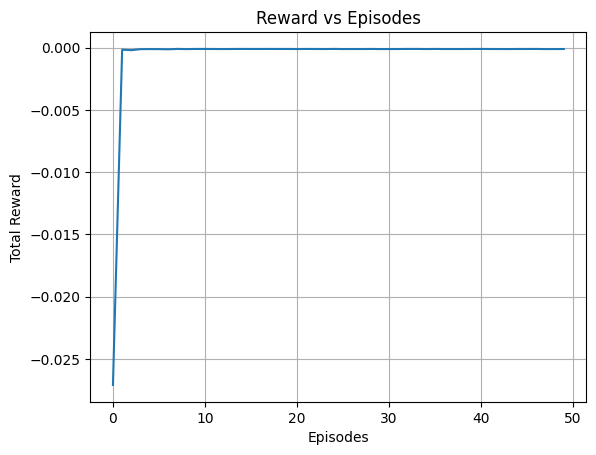

Episode 1/10, Total Reward: -9.999999999999982e-05
Episode 2/10, Total Reward: -9.999999999999982e-05
Episode 3/10, Total Reward: -9.999999999999982e-05
Episode 4/10, Total Reward: -9.999999999999982e-05
Episode 5/10, Total Reward: -9.999999999999982e-05
Episode 6/10, Total Reward: -9.999999999999982e-05
Episode 7/10, Total Reward: -9.999999999999982e-05
Episode 8/10, Total Reward: -9.999999999999982e-05
Episode 9/10, Total Reward: -9.999999999999982e-05
Episode 10/10, Total Reward: -9.999999999999982e-05
Parameters: {'learning_rate': 0.001, 'discount_factor': 0.99, 'exploration_rate': 0.1, 'exploration_decay': 0.99}, Average Reward: -9.99999999999998e-05
Testing parameters: {'learning_rate': 0.001, 'discount_factor': 0.99, 'exploration_rate': 0.1, 'exploration_decay': 0.95}
Q-table loaded from q_table_79.pkl.
Episode 1/50, Total Reward: -0.00018199999999999973
Episode 2/50, Total Reward: -0.0001239999999999998
Episode 3/50, Total Reward: -0.00017999999999999977
Episode 4/50, Total Rew

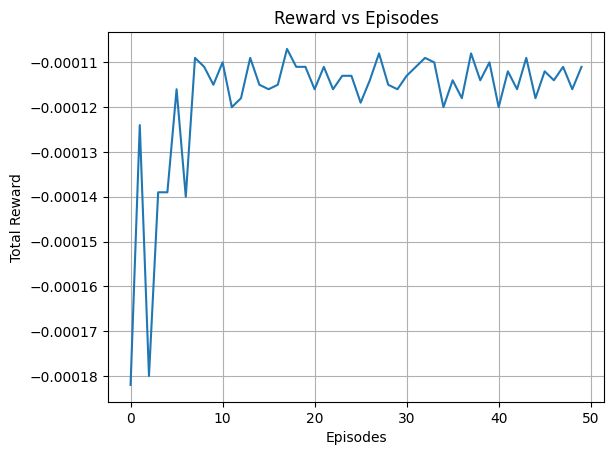

Episode 1/10, Total Reward: -0.0001029999999999998
Episode 2/10, Total Reward: -0.0001029999999999998
Episode 3/10, Total Reward: -0.0001029999999999998
Episode 4/10, Total Reward: -0.0001029999999999998
Episode 5/10, Total Reward: -0.0001029999999999998
Episode 6/10, Total Reward: -0.0001029999999999998
Episode 7/10, Total Reward: -0.0001029999999999998
Episode 8/10, Total Reward: -0.0001029999999999998
Episode 9/10, Total Reward: -0.0001029999999999998
Episode 10/10, Total Reward: -0.0001029999999999998
Parameters: {'learning_rate': 0.001, 'discount_factor': 0.99, 'exploration_rate': 0.1, 'exploration_decay': 0.95}, Average Reward: -0.00010299999999999982
Testing parameters: {'learning_rate': 0.001, 'discount_factor': 0.99, 'exploration_rate': 0.1, 'exploration_decay': 0.9}
Q-table loaded from q_table_80.pkl.
Episode 1/50, Total Reward: -0.16522700000000012
Episode 2/50, Total Reward: -0.00012799999999999978
Episode 3/50, Total Reward: -0.0001729999999999998
Episode 4/50, Total Rewar

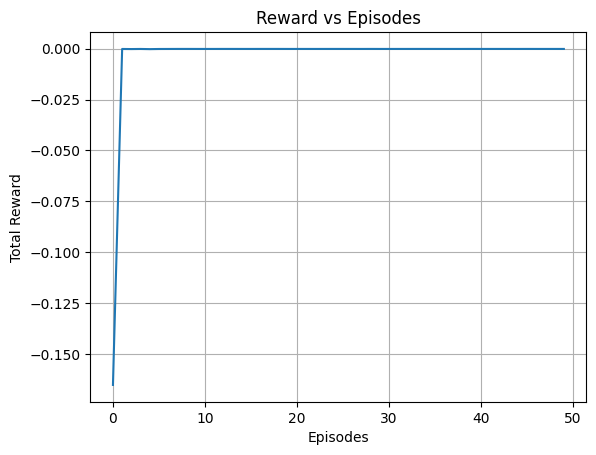

Episode 1/10, Total Reward: -9.999999999999982e-05
Episode 2/10, Total Reward: -9.999999999999982e-05
Episode 3/10, Total Reward: -9.999999999999982e-05
Episode 4/10, Total Reward: -9.999999999999982e-05
Episode 5/10, Total Reward: -9.999999999999982e-05
Episode 6/10, Total Reward: -9.999999999999982e-05
Episode 7/10, Total Reward: -9.999999999999982e-05
Episode 8/10, Total Reward: -9.999999999999982e-05
Episode 9/10, Total Reward: -9.999999999999982e-05
Episode 10/10, Total Reward: -9.999999999999982e-05
Parameters: {'learning_rate': 0.001, 'discount_factor': 0.99, 'exploration_rate': 0.1, 'exploration_decay': 0.9}, Average Reward: -9.99999999999998e-05
Best parameters: {'learning_rate': 0.1, 'discount_factor': 0.95, 'exploration_rate': 1.0, 'exploration_decay': 0.99} with average reward: -9.99999999999998e-05
Episode 1/100, Total Reward: -0.2243650000000001
Episode 2/100, Total Reward: -0.5805639999999999
Episode 3/100, Total Reward: -0.2853240000000001
Episode 4/100, Total Reward: -

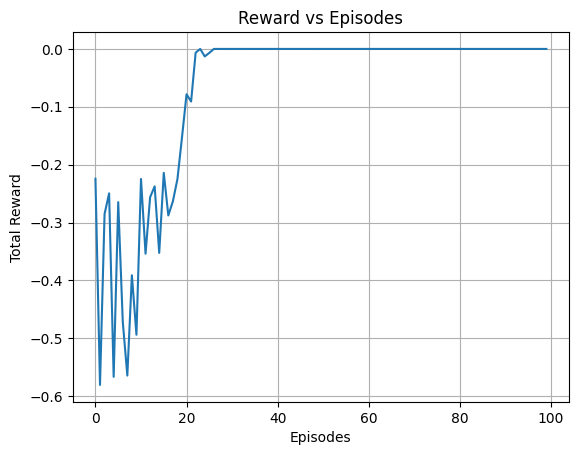

Episode 1/10, Total Reward: -0.00014999999999999974
Episode 2/10, Total Reward: -0.00014999999999999974
Episode 3/10, Total Reward: -0.00014999999999999974
Episode 4/10, Total Reward: -0.00014999999999999974
Episode 5/10, Total Reward: -0.00014999999999999974
Episode 6/10, Total Reward: -0.00014999999999999974
Episode 7/10, Total Reward: -0.00014999999999999974
Episode 8/10, Total Reward: -0.00014999999999999974
Episode 9/10, Total Reward: -0.00014999999999999974
Episode 10/10, Total Reward: -0.00014999999999999974
Active flags for each episode: [['-O1', '-O2', '-O3', '-fno-inline'], ['-O1', '-O2', '-O3', '-fno-inline'], ['-O1', '-O2', '-O3', '-fno-inline'], ['-O1', '-O2', '-O3', '-fno-inline'], ['-O1', '-O2', '-O3', '-fno-inline'], ['-O1', '-O2', '-O3', '-fno-inline'], ['-O1', '-O2', '-O3', '-fno-inline'], ['-O1', '-O2', '-O3', '-fno-inline'], ['-O1', '-O2', '-O3', '-fno-inline'], ['-O1', '-O2', '-O3', '-fno-inline']]
Inactive flags for each episode: [['-O0', '-Os', '-Ofast', '-Og'], 

In [ ]:
def train(agent, env, episodes=100):
    rewards = []
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0

        for step in range(100):
            action = agent.choose_action(state)
            next_state, reward, done = env.step(action)
            agent.learn(state, action, reward, next_state)
            agent.store_experience(state, action, reward, next_state)
            state = next_state
            total_reward += reward

            if done:
                break

        agent.experience_replay()
        rewards.append(total_reward)
        print(f"Episode {episode + 1}/{episodes}, Total Reward: {total_reward}")

    agent.save_q_table()

    plt.plot(range(episodes), rewards)
    plt.xlabel('Episodes')
    plt.ylabel('Total Reward')
    plt.title('Reward vs Episodes')
    plt.grid(True)
    plt.show()

def evaluate_rewards(agent, env, episodes=10):
    total_rewards = []
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0

        for step in range(100):
            action = agent.choose_action(state)
            next_state, reward, done = env.step(action)
            state = next_state
            total_reward += reward

            if done:
                break

        total_rewards.append(total_reward)
        print(f"Episode {episode + 1}/{episodes}, Total Reward: {total_reward}")

    return total_rewards

def parameter_tuning(env, param_grid, episodes=100, eval_episodes=10):
    best_params = None
    best_reward = float('-inf')

    for i, params in enumerate(param_grid):
        q_table_file = f'q_table_{i}.pkl'
        print(f"Testing parameters: {params}")
        agent = QLearningAgent(
            state_space=env.state_space,
            action_space=env.action_space,
            learning_rate=params['learning_rate'],
            discount_factor=params['discount_factor'],
            exploration_rate=params['exploration_rate'],
            exploration_decay=params['exploration_decay'],
            q_table_file=q_table_file
        )

        train(agent, env, episodes=episodes)
        total_rewards = evaluate_rewards(agent, env, episodes=eval_episodes)
        average_reward = np.mean(total_rewards)

        print(f"Parameters: {params}, Average Reward: {average_reward}")

        if average_reward > best_reward:
            best_reward = average_reward
            best_params = params
            print(f"New best parameters: {best_params} with average reward: {best_reward}")

    print(f"Best parameters: {best_params} with average reward: {best_reward}")
    return best_params

# Example execution
# Assuming new_code_path and gcc_flags are defined elsewhere and check_compatible_flags is implemented
compatible_flags, non_compatible_flags = check_compatible_flags(new_code_path, gcc_flags)

print("Compatible GCC Flags:")
print(compatible_flags)
print("\nNon-Compatible GCC Flags:")
print(non_compatible_flags)

# Initialize environment with compatible flags
env = CompilerEnv(new_code_path, compatible_flags)

# Define the parameter grid for tuning
param_grid = [
    {'learning_rate': lr, 'discount_factor': gamma, 'exploration_rate': epsilon, 'exploration_decay': decay}
    for lr, gamma, epsilon, decay in product(
        [0.1, 0.01, 0.001],
        [0.9, 0.95, 0.99],
        [1.0, 0.5, 0.1],
        [0.99, 0.95, 0.9]
    )
]

# Perform parameter tuning
best_params = parameter_tuning(env, param_grid, episodes=50, eval_episodes=10)

if best_params:
    # Initialize the best agent
    best_q_table_file = 'best_q_table.pkl'
    agent = QLearningAgent(
        state_space=env.state_space,
        action_space=env.action_space,
        learning_rate=best_params['learning_rate'],
        discount_factor=best_params['discount_factor'],
        exploration_rate=best_params['exploration_rate'],
        exploration_decay=best_params['exploration_decay'],
        q_table_file=best_q_table_file
    )

    # Train the agent with the best parameters
    train(agent, env)

    # Evaluate the agent on the new C file and get the arrays of active, inactive flags and all states
    active_flags, inactive_flags, all_states = evaluate(agent, env)
    print("Active flags for each episode:", active_flags)
    print("Inactive flags for each episode:", inactive_flags)
    print("All states for each episode:", all_states)

    # Interpret the active and inactive flags
    for episode in range(len(all_states)):
        active_flags_str = ', '.join(active_flags[episode])
        inactive_flags_str = ', '.join(inactive_flags[episode])
        print(f"Episode {episode + 1}: Active flags - {active_flags_str}")
        print(f"Episode {episode + 1}: Inactive flags - {inactive_flags_str}")
        print(f"Episode {episode + 1}: All states - {all_states[episode]}")
        print("-----------------------------------------------------------")
else:
    print("No best parameters found.")


In [ ]:
print("Best parameters:", best_params)

Best parameters: {'learning_rate': 0.1, 'discount_factor': 0.95, 'exploration_rate': 1.0, 'exploration_decay': 0.99}


# Final Model Tranning

In [ ]:
import os
import subprocess
import pickle
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

class CompilerEnv:
    def __init__(self, code_path):
        self.code_path = code_path
        self.flags = compatible_flags #['-O0', '-O1', '-O2', '-O3', '-Os', '-Ofast', '-Og', '-fno-inline',]
        self.state_space = len(self.flags)
        self.action_space = len(self.flags)
        self.current_state = tuple([0] * self.state_space)

    def reset(self):
        self.current_state = tuple([0] * self.state_space)
        return self.current_state

    def compile_and_measure(self, flags):
        flags_str = ' '.join([self.flags[i] for i, flag in enumerate(flags) if flag])
        compile_command = f"gcc {self.code_path} {flags_str} -o output"
        run_command = "./output"

        try:
            compile_result = subprocess.run(compile_command, shell=True, capture_output=True, text=True, timeout=10)
            if compile_result.returncode != 0:
                print("Compilation failed:", compile_result.stderr)
                return float('inf')

            subprocess.run(f"chmod +x output", shell=True)
            run_result = subprocess.run(run_command, shell=True, capture_output=True, text=True, timeout=10)
            if run_result.returncode != 0:
                print("Execution failed:", run_result.stderr)
                return float('inf')

            output_lines = run_result.stdout.strip().split('\n')
            execution_time = float(output_lines[-1])
            return execution_time

        except subprocess.TimeoutExpired:
            print("Execution timed out")
            return float('inf')

    def step(self, action):
        current_flags = list(self.current_state)
        current_flags[action] = 1 - current_flags[action]
        self.current_state = tuple(current_flags)

        execution_time = self.compile_and_measure(self.current_state)
        reward = -execution_time

        return self.current_state, reward, False

    def render(self):
        print(f"State: {self.current_state}")


'''
best_q_table_file = 'best_q_table.pkl'
agent = QLearningAgent(
    state_space=env.state_space,
    action_space=env.action_space,
    learning_rate=best_params['learning_rate'],
    discount_factor=best_params['discount_factor'],
    exploration_rate=best_params['exploration_rate'],
    exploration_decay=best_params['exploration_decay'],
    q_table_file=best_q_table_file
)
'''
class QLearningAgent:
    def __init__(self, state_space, action_space,
                  learning_rate=best_params['learning_rate'],
                  discount_factor=best_params['discount_factor'],
                  exploration_rate=best_params['exploration_rate'],
                  exploration_decay=best_params['exploration_decay'],
                  q_table_file='best_q_table.pkl'):

        self.state_space = state_space
        self.action_space = action_space
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = exploration_rate
        self.epsilon_decay = exploration_decay
        self.q_table_file = q_table_file
        self.q_table = self.load_q_table()
        self.memory = deque(maxlen=2000)  # Using deque for experience replay memory
        self.batch_size = 32

    def choose_action(self, state):
        if np.random.uniform(0, 1) < self.epsilon:
            action = np.random.choice(self.action_space)
        else:
            state_actions = self.q_table.get(state, np.zeros(self.action_space))
            action = np.argmax(state_actions)
        return action

    def learn(self, state, action, reward, next_state):
        if state not in self.q_table:
            self.q_table[state] = np.zeros(self.action_space)
        if next_state not in self.q_table:
            self.q_table[next_state] = np.zeros(self.action_space)

        predict = self.q_table[state][action]
        target = reward + self.gamma * np.max(self.q_table[next_state])
        self.q_table[state][action] += self.lr * (target - predict)
        self.epsilon *= self.epsilon_decay

    def save_q_table(self):
        with open(self.q_table_file, 'wb') as f:
            pickle.dump(self.q_table, f)
        print("Q-table saved.")

    def load_q_table(self):
        if os.path.exists(self.q_table_file):
            with open(self.q_table_file, 'rb') as f:
                print("Q-table loaded.")
                return pickle.load(f)
        else:
            return {}

    def store_experience(self, state, action, reward, next_state):
        self.memory.append((state, action, reward, next_state))

    def experience_replay(self):
        if len(self.memory) < self.batch_size:
            return
        minibatch = random.sample(self.memory, self.batch_size)
        for state, action, reward, next_state in minibatch:
            self.learn(state, action, reward, next_state)

def train(agent, env, episodes):
    rewards = []
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0

        for step in range(100):
            action = agent.choose_action(state)
            next_state, reward, done = env.step(action)
            agent.learn(state, action, reward, next_state)
            agent.store_experience(state, action, reward, next_state)
            state = next_state
            total_reward += reward

            if done:
                break

        agent.experience_replay()
        rewards.append(total_reward)
        print(f"Episode {episode + 1}/{episodes}, Total Reward: {total_reward}")
        #print(f"state {state}, action {action}")

    agent.save_q_table()

    plt.plot(range(episodes), rewards)
    plt.xlabel('Episodes')
    plt.ylabel('Total Reward')
    plt.title('Reward vs Episodes')
    plt.show()

def evaluate(agent, env, episodes=10):
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0

        for step in range(100):
            action = agent.choose_action(state)
            next_state, reward, done = env.step(action)
            state = next_state
            total_reward += reward

            if done:
                break

        print(f"Episode {episode + 1}/{episodes}, Total Reward: {total_reward}")

# Path to the new C file you want to test
new_code_path = 'sum.c'  # Change this to the path of your new code

# Initialize environment and agent with the new C file
env = CompilerEnv(new_code_path)
agent = QLearningAgent(env.state_space, env.action_space)

# Train the agent on the new C file
train(agent, env, episodes=50)

# Evaluate the agent on the new C file
evaluate(agent, env, episodes=10)


TypeError: 'NoneType' object is not subscriptable

In [ ]:
import pickle

def print_pickle_file(pickle_file_path):
    with open(pickle_file_path, 'rb') as f:
        data = pickle.load(f)
    print(data)

# Example usage

pickle_file_path = 'best_q_table.pkl'
print_pickle_file(pickle_file_path)


{(0, 0, 0, 0, 0, 0, 0, 0): array([-3.41410000e-03, -1.06584300e-03, -3.89295739e-06, -3.38173467e-06,
       -3.19529102e-06, -3.22813337e-06, -1.38434000e-03, -5.82294800e-03]), (0, 0, 0, 1, 0, 0, 0, 0): array([-2.84194087e-06, -3.08388587e-06, -2.82803457e-06, -1.43085390e-02,
       -2.75268812e-06, -2.78171740e-06, -2.01523600e-03, -2.80360005e-06]), (0, 0, 0, 1, 0, 1, 0, 0): array([-2.69142604e-06, -2.66600980e-06, -2.70080651e-06, -2.68854432e-06,
       -2.64455151e-06, -2.72998506e-06, -1.37750000e-03, -2.81115524e-06]), (0, 0, 0, 1, 1, 1, 0, 0): array([-2.69467488e-06, -2.66831967e-06, -2.81824967e-06, -2.73612145e-06,
       -2.68553075e-06, -2.84647906e-06, -7.95300000e-04, -2.75772603e-06]), (0, 0, 0, 1, 1, 0, 0, 0): array([-2.57215841e-06, -2.65666337e-06, -2.58586793e-06, -7.90660241e-06,
       -2.65013196e-06, -2.66576783e-06, -7.31300000e-04, -2.66302867e-06]), (0, 0, 1, 1, 1, 0, 0, 0): array([-2.58190929e-06, -2.42331355e-06, -2.50888230e-06, -2.43842843e-06,
       -